In [46]:
import numpy as np
import pandas as pd
from sklearn.compose import make_column_selector as selector
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.metrics import matthews_corrcoef
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import make_pipeline
from sklearn.ensemble import RandomForestClassifier
import xgboost as xgb
import csv
import matplotlib.pyplot as plt
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis

In [47]:
# Inizializzazione e
# Preprocessing: eliminate feature con valori costanti (1)
# Preprocessing: cambiate le varie anomalie con nomi diversi in 'anomaly' (2)
# Preprocessing: mappare 0: normal 1:anomaly (3)
def preprocessing_base(csv_path):
    # Inizializzazione
    df = pd.read_csv(csv_path)

    # Preprocessing 1
    df=df.loc[:, (df != df.iloc[0]).any()]

    # Preprocessing 2
    df.loc[df['label'] != 'normal', 'label'] = 'anomaly'

    # Preprocessing 3
    df['label'] = df['label'].map({'normal': 0, 'anomaly': 1})

    y = df['label']
    X = df.drop(columns='label')
    return X,y,df



In [48]:
X,y,df=preprocessing_base('preprocessed_arancino_datasets/unifi_filtered.csv')

In [49]:
def split_numerical_categorical_columns(X):
    # Divide in features "numerical" e "categorical"
    numerical_columns_selector = selector(dtype_exclude=object)
    categorical_columns_selector = selector(dtype_include=object)

    numerical_columns = numerical_columns_selector(X)
    categorical_columns = categorical_columns_selector(X)
    # Preprocessing: Scaling e Encoding
    categorical_preprocessor = OneHotEncoder(handle_unknown="ignore")
    numerical_preprocessor = StandardScaler()

    preprocessor = ColumnTransformer(
        [
            ("one-hot-encoder", categorical_preprocessor, categorical_columns),
            ("standard_scaler", numerical_preprocessor, numerical_columns),
        ]
    )
    return preprocessor


In [50]:
def my_LogisticRegression_pipeline(preprocessor, X_train, y_train):
    # LogisticRegression training
    modelLog = make_pipeline(preprocessor, LogisticRegression(max_iter=1000))
    modelLog.fit(X_train, y_train)
    return modelLog

In [51]:
def my_LDA_pipeline(preprocessor,X_train,y_train):
    #LDA training
    modelLDA=make_pipeline(preprocessor,LinearDiscriminantAnalysis())
    modelLDA.fit(X_train,y_train)
    return modelLDA

In [52]:
#Utility per scrivere su file csv
def is_csv_empty(file_path):
    with open(file_path, 'r') as csvfile:
        csvreader = csv.reader(csvfile)
        try:
            first_row = next(csvreader)  # Tenta di leggere la prima riga
            return False if first_row else True  # Se c'è una riga, il file non è vuoto
        except StopIteration:  # Se il reader raggiunge la fine senza righe
            return True

In [53]:
def get_mcc (csv_name,model, X_test, y_test,csv_note=None):
    MCC=(matthews_corrcoef(y_test, model.predict(X_test))+1)/2 # MCC scalato a [0,1]

    if csv_note is not None:
        with open(csv_name, 'a', newline='') as file:
            fieldnames = ['csv_note','MCC']
            writer = csv.DictWriter(file, fieldnames=fieldnames)
            if is_csv_empty(csv_name):
                writer.writeheader()

            writer.writerow({'csv_note': csv_note,'MCC': MCC})

    return MCC

In [54]:
def get_accuracy_cross_val (csv_name,model, X_train, y_train,csv_note=None):
    accuracies_lr = cross_val_score(estimator=model, X=X_train, y=y_train)
    avg_accuracy=np.mean(accuracies_lr)

    if csv_note is not None:
        with open(csv_name, 'a', newline='') as file:
            fieldnames = ['csv_note','Accuracy']
            writer = csv.DictWriter(file, fieldnames=fieldnames)
            if is_csv_empty(csv_name):
                writer.writeheader()

            writer.writerow({'csv_note': csv_note,'Accuracy': avg_accuracy})
    
    return avg_accuracy

In [55]:
def my_RandomForest_pipeline(preprocessor, X_train, y_train):
    # RandomForest training
    modelRand = make_pipeline(preprocessor, RandomForestClassifier(random_state=42)) 
    modelRand.fit(X_train, y_train)
    return modelRand

In [56]:
def my_XGB_pipeline(preprocessor, X_train, y_train):
    # XGB training
    modelXGB = make_pipeline(preprocessor, xgb.XGBClassifier(random_state=42)) 
    modelXGB.fit(X_train, y_train)
    return modelXGB

In [57]:
def window_input_difference(window_length: int, data: pd.DataFrame) -> pd.DataFrame:

    df = data.copy()

    i = 1
    while i < window_length:
        for x in data.columns:
            df[f'{x}_{i}'] =data[f'{x}']-data[f'{x}'].shift(i)
        i = i + 1

    # Drop delle righe dove è presente valore NaN
    df = df.dropna(axis=0)

    # Drop labels
    for i in range(1, window_length):
        df = df.drop(columns=f'label_{i}')

    return df

In [58]:
def window_input_moving_average(window_length: int, data: pd.DataFrame) -> pd.DataFrame:

    df = data.copy()

    for x in data.columns:
        df[f'{x}_ma']=df[f'{x}'].rolling(window_length).mean()

    # Drop delle righe dove è presente valore NaN
    df = df.dropna(axis=0)

    # Drop labels
    df = df.drop(columns=f'label_ma')

    return df

In [59]:
def speed_detection_score(csv_name,model, X_test: pd.DataFrame, y_test: pd.DataFrame,csv_note=None):
    X_test['label'] = y_test
    X_test=X_test.sort_index()
    
    X_test_anomalies = X_test[X_test['label'] == 1]
    X_test_anomalies = X_test_anomalies.drop(columns='label')

    predictions = model.predict(X_test_anomalies)

    predictions = split_array(predictions, 5)

    counters={}
    for i in range(5):
        counters[f'count_{i}']=0

    for x in predictions:
        if (x[0] == 1):
            counters['count_0'] = counters['count_0']+1
        elif (x[1] == 1):
            counters['count_1'] = counters['count_1']+1
        elif (x[2] == 1):
            counters['count_2'] = counters['count_2']+1
        elif (x[3] == 1):
            counters['count_3'] = counters['count_3']+1
        elif (x[4] == 1):
            counters['count_4'] = counters['count_4']+1

    score=(counters['count_0']*1+counters['count_1']*0.8**2+counters['count_2']*0.6**2+counters['count_3']*0.4**2+counters['count_4']*0.2**2)/(counters['count_0']+counters['count_1']+counters['count_2']+counters['count_3']+counters['count_4'])

    if csv_note is not None:
        with open(csv_name, 'a', newline='') as file:
            fieldnames = ['csv_note','speed_0', 'speed_1','speed_2','speed_3','speed_4']
            writer = csv.DictWriter(file, fieldnames=fieldnames)
            if is_csv_empty(csv_name):
                writer.writeheader()

            writer.writerow({'csv_note': csv_note,'speed_0': counters['count_0'],'speed_1':counters['count_1'],'speed_2': counters['count_2'],'speed_3':counters['count_3'],'speed_4':counters['count_4']})
        
    return score


def split_array(array, size): #Questa funzione fa questo --> DA [0,1,1,1,1,1,1,1,1,1] A [[0,1,1,1,1],[1,1,1,1,1]]
    split_array = []
    for i in range(0, len(array), size):
        split_array.append(array[i:i+size])
    split_array = [subarray for subarray in split_array if len(subarray) == 5]
    
    return split_array

In [60]:
def feature_importance_tree(note, model ,X_train):
    feature_importances = model.steps[-1][1].feature_importances_
    features = X_train.columns
    importances_df = pd.DataFrame(data={
    'Feature': features,
    'Importance': feature_importances
    })
    importances_df = importances_df.sort_values(by='Importance', ascending=False).head(20)

    plt.bar(x=importances_df['Feature'], height=importances_df['Importance'])
    plt.title(f'{note}')
    plt.xticks(rotation='vertical')
    plt.savefig(f'{note}',bbox_inches='tight')
    plt.show()

    return importances_df
   

In [61]:
def feature_importance_coef(note, model ,X_train):
    feature_importances = model.steps[-1][1].coef_[0]
    features = X_train.columns
    importances_df = pd.DataFrame(data={
    'Feature': features,
    'Importance': np.abs(feature_importances)
    })
    importances_df = importances_df.sort_values(by='Importance', ascending=False).head(20)

    plt.bar(x=importances_df['Feature'], height=importances_df['Importance'])
    plt.title(f'{note}')
    plt.xticks(rotation='vertical')
    plt.savefig(f'{note}',bbox_inches='tight')
    plt.show()

    return importances_df
   

In [62]:
def training_classic(shuffle,X,y,fig_details):
    #TRAINING MODELLI CLASSICI
    preprocessor=split_numerical_categorical_columns(X)
    # train_test_split
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, shuffle=shuffle) 

    modelXGBClassic=my_XGB_pipeline(preprocessor,X_train,y_train)

    modelLogClassic=my_LogisticRegression_pipeline(preprocessor,X_train,y_train)

    modelRandClassic=my_RandomForest_pipeline(preprocessor,X_train,y_train)

    modelLDAClassic=my_LDA_pipeline(preprocessor,X_train,y_train)

    classic_models={
        'XGB':modelXGBClassic,
        'LogisticRegression':modelLogClassic,
        'RandomForest':modelRandClassic,
        'LDA':modelLDAClassic
    }

    feature_importance_tree('Feature Importance XGB Classic_'+fig_details,classic_models['XGB'],X_train)
    feature_importance_coef('Feature Importance Logistic Regression Classic_'+fig_details,classic_models['LogisticRegression'],X_train)
    feature_importance_tree('Feature Importance Random Forest Classic_'+fig_details,classic_models['RandomForest'],X_train)
    feature_importance_coef('Feature Importance LDA Classic_'+fig_details,classic_models['LDA'],X_train)
    
    return classic_models,X_train,y_train,X_test,y_test

In [63]:
#Creo delle mappe che contengono rispettivamente MCC, accuracy e speed score per ogni modello
def map_creation_classic(models,X_train,y_train,X_test,y_test,csv_details):
    mcc_map={
        'Logistic Regression Classic':get_mcc('mcc_'+csv_details+'.csv',models['LogisticRegression'],X_test,y_test,'Logistic Regression Classic'),
        'XGB Classic':get_mcc('mcc_'+csv_details+'.csv',models['XGB'],X_test,y_test,'XGB Classic'),
        'Random Forest Classic':get_mcc('mcc_'+csv_details+'.csv',models['RandomForest'],X_test,y_test,'Random Forest Classic'),
        'LDA Classic':get_mcc('mcc_'+csv_details+'.csv',models['LDA'],X_test,y_test,'LDA Classic')
    }

    accuracy_map={
        'Logistic Regression Classic':get_accuracy_cross_val('accuracy_'+csv_details+'.csv',models['LogisticRegression'],X_train,y_train,'Logistic Regression Classic'),
        'XGB Classic':get_accuracy_cross_val('accuracy_'+csv_details+'.csv',models['XGB'],X_train,y_train,'XGB Classic'),
        'Random Forest Classic':get_accuracy_cross_val('accuracy_'+csv_details+'.csv',models['RandomForest'],X_train,y_train,'Random Forest Classic'),
        'LDA Classic':get_accuracy_cross_val('accuracy_'+csv_details+'.csv',models['LDA'],X_train,y_train,'LDA Classic')
    }

    speed_map={
        'Logistic Regression Classic':speed_detection_score('speed_'+csv_details+'.csv',models['LogisticRegression'],X_test,y_test,'Logistic Regression Classic'),
        'XGB Classic':speed_detection_score('speed_'+csv_details+'.csv',models['XGB'],X_test,y_test,'XGB Classic'),
        'Random Forest Classic':speed_detection_score('speed_'+csv_details+'.csv',models['RandomForest'],X_test,y_test,'Random Forest Classic'),
        'LDA Classic':speed_detection_score('speed_'+csv_details+'.csv',models['LDA'],X_test,y_test,'LDA Classic')
    }
    return mcc_map,accuracy_map,speed_map

In [64]:
def training_ts_diff(shuffle,X,y,df,size,fig_details):    
    #TRAINING MODELLI TIME SERIES
    new_df_difference = window_input_difference(size, df)
    y = new_df_difference['label']
    X = new_df_difference.drop(columns='label')

    preprocessor=split_numerical_categorical_columns(X)

    # train_test_split
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, shuffle=shuffle)

    modelLogTS=my_LogisticRegression_pipeline(preprocessor,X_train,y_train)

    modelRandTS=my_RandomForest_pipeline(preprocessor,X_train,y_train)

    modelXGBTS=my_XGB_pipeline(preprocessor,X_train,y_train)

    modelLDATS=my_LDA_pipeline(preprocessor,X_train,y_train)

    ts_diff_models={
        'XGB':modelXGBTS,
        'LogisticRegression':modelLogTS,
        'RandomForest':modelRandTS,
        'LDA':modelLDATS
    }

    feature_importance_tree('Feature Importance XGB TS Diff_'+fig_details,ts_diff_models['XGB'],X_train)
    feature_importance_coef('Feature Importance Logistic Regression TS Diff_'+fig_details,ts_diff_models['LogisticRegression'],X_train)
    feature_importance_tree('Feature Importance Random Forest TS Diff_'+fig_details,ts_diff_models['RandomForest'],X_train)
    feature_importance_coef('Feature Importance LDA TS Diff_'+fig_details,ts_diff_models['LDA'],X_train)
    

    return ts_diff_models,X_train,y_train,X_test,y_test




In [65]:
#Update delle mappe
def map_update_TS(models,TS_type,X_train,y_train,X_test,y_test,mcc_map,accuracy_map,speed_map,csv_details):
    keys=[None,None,None,None]
    if(TS_type=='Diff'):
        keys=['Logistic Regression TS Diff','XGB TS Diff','Random Forest TS Diff','LDA TS Diff']
    elif (TS_type=='MA'):
        keys=['Logistic Regression TS MA','XGB TS MA','Random Forest TS MA','LDA TS MA']

    mcc_map.update({
        keys[0]:get_mcc('mcc_'+csv_details+'.csv',models['LogisticRegression'],X_test,y_test,keys[0]),
        keys[1]:get_mcc('mcc_'+csv_details+'.csv',models['XGB'],X_test,y_test,keys[1]),
        keys[2]:get_mcc('mcc_'+csv_details+'.csv',models['RandomForest'],X_test,y_test,keys[2]),
        keys[3]:get_mcc('mcc_'+csv_details+'.csv',models['LDA'],X_test,y_test,keys[3])
    })

    accuracy_map.update({
        keys[0]:get_accuracy_cross_val('accuracy_'+csv_details+'.csv',models['LogisticRegression'],X_train,y_train,keys[0]),
        keys[1]:get_accuracy_cross_val('accuracy_'+csv_details+'.csv',models['XGB'],X_train,y_train,keys[1]),
        keys[2]:get_accuracy_cross_val('accuracy_'+csv_details+'.csv',models['RandomForest'],X_train,y_train,keys[2]),
        keys[3]:get_accuracy_cross_val('accuracy_'+csv_details+'.csv',models['LDA'],X_train,y_train,keys[3])
    })

    speed_map.update({
        keys[0]:speed_detection_score('speed_'+csv_details+'.csv',models['LogisticRegression'],X_test,y_test,keys[0]),
        keys[1]:speed_detection_score('speed_'+csv_details+'.csv',models['XGB'],X_test,y_test,keys[1]),
        keys[2]:speed_detection_score('speed_'+csv_details+'.csv',models['RandomForest'],X_test,y_test,keys[2]),
        keys[3]:speed_detection_score('speed_'+csv_details+'.csv',models['LDA'],X_test,y_test,keys[3])
    })
    return mcc_map,accuracy_map,speed_map

In [66]:
def training_ts_ma(shuffle,X,y,df,size,fig_details):
     #TRAINING MODELLI TIME SERIES MOVING AVERAGE
    new_df_moving_average = window_input_moving_average(size, df)
    y = new_df_moving_average['label']
    X = new_df_moving_average.drop(columns='label')

    preprocessor=split_numerical_categorical_columns(X)

    # train_test_split
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, shuffle=shuffle)

    modelLogTSMA=my_LogisticRegression_pipeline(preprocessor,X_train,y_train)

    modelRandTSMA=my_RandomForest_pipeline(preprocessor,X_train,y_train)

    modelXGBTSMA=my_XGB_pipeline(preprocessor,X_train,y_train)

    modelLDATSMA=my_LDA_pipeline(preprocessor,X_train,y_train)

    ts_ma_models={
        'XGB':modelXGBTSMA,
        'LogisticRegression':modelLogTSMA,
        'RandomForest':modelRandTSMA,
        'LDA':modelLDATSMA
    }

    feature_importance_tree('Feature Importance XGB TS MA_'+fig_details,ts_ma_models['XGB'],X_train)
    feature_importance_coef('Feature Importance Logistic Regression TS MA_'+fig_details,ts_ma_models['LogisticRegression'],X_train)
    feature_importance_tree('Feature Importance Random Forest TS MA_'+fig_details,ts_ma_models['RandomForest'],X_train)
    feature_importance_coef('Feature Importance LDA TS MA_'+fig_details,ts_ma_models['LDA'],X_train)

    return ts_ma_models,X_train,y_train,X_test,y_test

In [67]:
def progression_plot(ax,map,note):
    x_values = list(map.keys())
    y_values = list(map.values())
    ax.plot(x_values, y_values, marker='o', linestyle='-', label=note)
    ax.legend()

In [68]:
def mcc_accuracy_progression(mcc_map,accuracy_map,details):
    #MCC and Accuracy Progression

    #Definizione mappe
    logistic_mcc_map={}
    random_forest_mcc_map={}
    xgb_mcc_map={}
    lda_mcc_map={}

    logistic_accuracy_map={}
    random_forest_accuracy_map={}
    xgb_accuracy_map={}
    lda_accuracy_map={}

    #Assegna le coppie key-value alle rispettive mappe di appartenenza in base al modello
    for key, value in mcc_map.items():
        if 'Logistic' in key:
            logistic_mcc_map[key] = value
        if 'Random' in key:
            random_forest_mcc_map[key] = value
        if 'XGB' in key:
            xgb_mcc_map[key] = value
        if 'LDA' in key:
            lda_mcc_map[key] = value

    for key, value in accuracy_map.items():
        if 'Logistic' in key:
            logistic_accuracy_map[key] = value
        if 'Random' in key:
            random_forest_accuracy_map[key] = value
        if 'XGB' in key:
            xgb_accuracy_map[key] = value
        if 'LDA' in key:
            lda_accuracy_map[key] = value


    fig, (ax1, ax2, ax3, ax4) = plt.subplots(4, 1, figsize=(8, 12))
    fig.suptitle('MCC Progression')
    progression_plot(ax1,logistic_mcc_map,'Logistic_Regression_MCC_Progression')
    progression_plot(ax2,xgb_mcc_map,'XGB_MCC_Progression')
    progression_plot(ax3,random_forest_mcc_map,'Random_Forest_MCC_Progression')
    progression_plot(ax4,lda_mcc_map,'LDA_MCC_Progression')
    plt.savefig('MCC_Progression_'+details)

    fig, (ax1, ax2, ax3, ax4) = plt.subplots(4, 1, figsize=(8, 12))
    fig.suptitle('Accuracy Progression')
    progression_plot(ax1,logistic_accuracy_map,'Logistic_Regression_Accuracy_Progression')
    progression_plot(ax2,xgb_accuracy_map,'XGB_Accuracy_Progression')
    progression_plot(ax3,random_forest_accuracy_map,'Random_Forest_Accuracy_Progression')
    progression_plot(ax4,lda_accuracy_map,'LDA_Accuracy_Progression')
    plt.savefig('Accuracy_Progression_'+details)

    return logistic_mcc_map,random_forest_mcc_map,xgb_mcc_map,lda_mcc_map



In [69]:
def speed_progression(speed_map,details):
    #Speed Progression

    #Definizione mappe
    logistic_speed_map={}
    random_forest_speed_map={}
    xgb_speed_map={}
    lda_speed_map={}

    #Split maps
    for key, value in speed_map.items():
        if 'Logistic' in key:
            logistic_speed_map[key] = value
        if 'Random' in key:
            random_forest_speed_map[key] = value
        if 'XGB' in key:
            xgb_speed_map[key] = value
        if 'LDA' in key:
            lda_speed_map[key] = value

    fig, (ax1, ax2, ax3, ax4) = plt.subplots(4, 1, figsize=(8, 12))
    fig.suptitle('Detection Speed Progression')
    progression_plot(ax1,logistic_speed_map,'Logistic_Regression_Speed_Progression')
    progression_plot(ax2,xgb_speed_map,'XGB_Speed_Progression')
    progression_plot(ax3,random_forest_speed_map,'Random_Forest_Speed_Progression')
    progression_plot(ax4,lda_speed_map,'LDA_Speed_Progression')
    plt.savefig('Speed_Progression_'+details)

In [70]:
#Calcolo l'MCC di tutti i modelli usando come test set il dataset 'all3'
def mcc_all3(classic_models,ts_diff_models,ts_ma_models,size):
    X,y,df=preprocessing_base('preprocessed_arancino_datasets/all3.csv')

    mcc_all_map={
        'Logistic Regression Classic':get_mcc('',classic_models['LogisticRegression'],X,y),
        'XGB Classic':get_mcc('',classic_models['XGB'],X,y),
        'Random Forest Classic':get_mcc('',classic_models['RandomForest'],X,y),
        'LDA Classic':get_mcc('',classic_models['LDA'],X,y)
    }

    new_df_difference = window_input_difference(size, df)
    y = new_df_difference['label']
    X = new_df_difference.drop(columns='label')

    mcc_all_map.update({
        'Logistic Regression TS Diff':get_mcc('',ts_diff_models['LogisticRegression'],X,y),
        'XGB TS Diff':get_mcc('',ts_diff_models['XGB'],X,y),
        'Random Forest TS Diff':get_mcc('',ts_diff_models['RandomForest'],X,y),
        'LDA TS Diff':get_mcc('',ts_diff_models['LDA'],X,y)
    })

    new_df_moving_average=window_input_moving_average(size,df)
    y = new_df_moving_average['label']
    X = new_df_moving_average.drop(columns='label')

    mcc_all_map.update({
        'Logistic Regression TS MA':get_mcc('',ts_ma_models['LogisticRegression'],X,y),
        'XGB TS MA':get_mcc('',ts_ma_models['XGB'],X,y),
        'Random Forest TS MA':get_mcc('',ts_ma_models['RandomForest'],X,y),
        'LDA TS MA':get_mcc('',ts_ma_models['LDA'],X,y)
    })
    
    return mcc_all_map

In [71]:
def mcc_all3_plot(mcc_all_map,logistic_mcc_map,random_forest_mcc_map,xgb_mcc_map,lda_mcc_map,details):    
    #Definizione mappe
    logistic_mcc_all_map={}
    random_forest_mcc_all_map={}
    xgb_mcc_all_map={}
    lda_mcc_all_map={}

    #Split maps
    for key, value in mcc_all_map.items():
        if 'Logistic' in key:
            logistic_mcc_all_map[key] = value
        if 'Random' in key:
            random_forest_mcc_all_map[key] = value
        if 'XGB' in key:
            xgb_mcc_all_map[key] = value
        if 'LDA' in key:
            lda_mcc_all_map[key] = value

    x_values = list(logistic_mcc_all_map.keys())
    y_values=list(logistic_mcc_map.values())
    y_all_values = list(logistic_mcc_all_map.values())

    fig, (ax1, ax2, ax3, ax4) = plt.subplots(4, 1, figsize=(8, 12))
    ax1.plot(x_values, y_values, marker='o', linestyle='-',label='Uni')
    ax1.plot(x_values, y_all_values, marker='o', linestyle='-',label='All3')
    ax1.legend()

    x_values = list(xgb_mcc_map.keys())
    y_values=list(xgb_mcc_map.values())
    y_all_values = list(xgb_mcc_all_map.values())

    ax2.plot(x_values, y_values, marker='o', linestyle='-',label='Uni')
    ax2.plot(x_values, y_all_values, marker='o', linestyle='-',label='All3')
    ax2.legend()

    x_values = list(random_forest_mcc_map.keys())
    y_values=list(random_forest_mcc_map.values())
    y_all_values = list(random_forest_mcc_all_map.values())

    ax3.plot(x_values, y_values, marker='o', linestyle='-',label='Uni')
    ax3.plot(x_values, y_all_values, marker='o', linestyle='-',label='All3')
    ax3.legend()

    x_values = list(lda_mcc_map.keys())
    y_values=list(lda_mcc_map.values())
    y_all_values = list(lda_mcc_all_map.values())

    ax4.plot(x_values, y_values, marker='o', linestyle='-',label='Uni')
    ax4.plot(x_values, y_all_values, marker='o', linestyle='-',label='All3')
    ax4.legend()

    fig.suptitle('MCC Comparison Uni-All3 '+details)
    plt.savefig('MCC Comparison Uni-All3 '+details)
    plt.show()


In [72]:
def main_1():
    X,y,df=preprocessing_base('preprocessed_arancino_datasets/unifi_filtered.csv')

    shuffle=True
    size=5
    details='win5_shufTrue'
    
    classic_models,X_train,y_train,X_test,y_test=training_classic(shuffle,X,y,details)
    mcc_map,accuracy_map,speed_map=map_creation_classic(classic_models,X_train,y_train,X_test,y_test,details)

    ts_diff_models,X_train,y_train,X_test,y_test=training_ts_diff(shuffle,X,y,df,size,details)
    mcc_map,accuracy_map,speed_map=map_update_TS(ts_diff_models,'Diff',X_train,y_train,X_test,y_test,mcc_map,accuracy_map,speed_map,details)

    ts_ma_models,X_train,y_train,X_test,y_test=training_ts_ma(shuffle,X,y,df,size,details)
    mcc_map,accuracy_map,speed_map=map_update_TS(ts_ma_models,'MA',X_train,y_train,X_test,y_test,mcc_map,accuracy_map,speed_map,details)

    logistic_mcc_map,random_forest_mcc_map,xgb_mcc_map,lda_mcc_map=mcc_accuracy_progression(mcc_map,accuracy_map,details)
    mcc_all_map=mcc_all3(classic_models,ts_diff_models,ts_ma_models,size)
    mcc_all3_plot(mcc_all_map,logistic_mcc_map,random_forest_mcc_map,xgb_mcc_map,lda_mcc_map,details)
    speed_progression(speed_map,details)

    

In [73]:
def main_2():
    X,y,df=preprocessing_base('preprocessed_arancino_datasets/unifi_filtered.csv')

    shuffle=False
    size=5
    details='win5_shufFalse'
    
    classic_models,X_train,y_train,X_test,y_test=training_classic(shuffle,X,y,details)
    mcc_map,accuracy_map,speed_map=map_creation_classic(classic_models,X_train,y_train,X_test,y_test,details)

    ts_diff_models,X_train,y_train,X_test,y_test=training_ts_diff(shuffle,X,y,df,size,details)
    mcc_map,accuracy_map,speed_map=map_update_TS(ts_diff_models,'Diff',X_train,y_train,X_test,y_test,mcc_map,accuracy_map,speed_map,details)

    ts_ma_models,X_train,y_train,X_test,y_test=training_ts_ma(shuffle,X,y,df,size,details)
    mcc_map,accuracy_map,speed_map=map_update_TS(ts_ma_models,'MA',X_train,y_train,X_test,y_test,mcc_map,accuracy_map,speed_map,details)

    logistic_mcc_map,random_forest_mcc_map,xgb_mcc_map,lda_mcc_map=mcc_accuracy_progression(mcc_map,accuracy_map,details)
    mcc_all_map=mcc_all3(classic_models,ts_diff_models,ts_ma_models,size)
    mcc_all3_plot(mcc_all_map,logistic_mcc_map,random_forest_mcc_map,xgb_mcc_map,lda_mcc_map,details)
    speed_progression(speed_map,details)

In [74]:
def main_3():
    X,y,df=preprocessing_base('preprocessed_arancino_datasets/unifi_filtered.csv')

    shuffle=False
    size=4
    details='win4_shufFalse'
    
    classic_models,X_train,y_train,X_test,y_test=training_classic(shuffle,X,y,details)
    mcc_map,accuracy_map,speed_map=map_creation_classic(classic_models,X_train,y_train,X_test,y_test,details)

    ts_diff_models,X_train,y_train,X_test,y_test=training_ts_diff(shuffle,X,y,df,size,details)
    mcc_map,accuracy_map,speed_map=map_update_TS(ts_diff_models,'Diff',X_train,y_train,X_test,y_test,mcc_map,accuracy_map,speed_map,details)

    ts_ma_models,X_train,y_train,X_test,y_test=training_ts_ma(shuffle,X,y,df,size,details)
    mcc_map,accuracy_map,speed_map=map_update_TS(ts_ma_models,'MA',X_train,y_train,X_test,y_test,mcc_map,accuracy_map,speed_map,details)

    logistic_mcc_map,random_forest_mcc_map,xgb_mcc_map,lda_mcc_map=mcc_accuracy_progression(mcc_map,accuracy_map,details)
    mcc_all_map=mcc_all3(classic_models,ts_diff_models,ts_ma_models,size)
    mcc_all3_plot(mcc_all_map,logistic_mcc_map,random_forest_mcc_map,xgb_mcc_map,lda_mcc_map,details)
    speed_progression(speed_map,details)

In [75]:
def main_4():
    X,y,df=preprocessing_base('preprocessed_arancino_datasets/unifi_filtered.csv')

    shuffle=False
    size=3
    details='win3_shufFalse'
    
    classic_models,X_train,y_train,X_test,y_test=training_classic(shuffle,X,y,details)
    mcc_map,accuracy_map,speed_map=map_creation_classic(classic_models,X_train,y_train,X_test,y_test,details)

    ts_diff_models,X_train,y_train,X_test,y_test=training_ts_diff(shuffle,X,y,df,size,details)
    mcc_map,accuracy_map,speed_map=map_update_TS(ts_diff_models,'Diff',X_train,y_train,X_test,y_test,mcc_map,accuracy_map,speed_map,details)

    ts_ma_models,X_train,y_train,X_test,y_test=training_ts_ma(shuffle,X,y,df,size,details)
    mcc_map,accuracy_map,speed_map=map_update_TS(ts_ma_models,'MA',X_train,y_train,X_test,y_test,mcc_map,accuracy_map,speed_map,details)

    logistic_mcc_map,random_forest_mcc_map,xgb_mcc_map,lda_mcc_map=mcc_accuracy_progression(mcc_map,accuracy_map,details)
    mcc_all_map=mcc_all3(classic_models,ts_diff_models,ts_ma_models,size)
    mcc_all3_plot(mcc_all_map,logistic_mcc_map,random_forest_mcc_map,xgb_mcc_map,lda_mcc_map,details)
    speed_progression(speed_map,details)

In [76]:
def main_5():
    X,y,df=preprocessing_base('preprocessed_arancino_datasets/unifi_filtered.csv')

    shuffle=False
    size=2
    details='win2_shufFalse'
    
    classic_models,X_train,y_train,X_test,y_test=training_classic(shuffle,X,y,details)
    mcc_map,accuracy_map,speed_map=map_creation_classic(classic_models,X_train,y_train,X_test,y_test,details)

    ts_diff_models,X_train,y_train,X_test,y_test=training_ts_diff(shuffle,X,y,df,size,details)
    mcc_map,accuracy_map,speed_map=map_update_TS(ts_diff_models,'Diff',X_train,y_train,X_test,y_test,mcc_map,accuracy_map,speed_map,details)

    ts_ma_models,X_train,y_train,X_test,y_test=training_ts_ma(shuffle,X,y,df,size,details)
    mcc_map,accuracy_map,speed_map=map_update_TS(ts_ma_models,'MA',X_train,y_train,X_test,y_test,mcc_map,accuracy_map,speed_map,details)

    logistic_mcc_map,random_forest_mcc_map,xgb_mcc_map,lda_mcc_map=mcc_accuracy_progression(mcc_map,accuracy_map,details)
    mcc_all_map=mcc_all3(classic_models,ts_diff_models,ts_ma_models,size)
    mcc_all3_plot(mcc_all_map,logistic_mcc_map,random_forest_mcc_map,xgb_mcc_map,lda_mcc_map,details)
    speed_progression(speed_map,details)

In [77]:
def main_6():
    X,y,df=preprocessing_base('preprocessed_arancino_datasets/unifi_filtered.csv')

    shuffle=False
    size=5
    details='win5_shufFalse_only10feature'
    
    classic_models,X_train,y_train,X_test,y_test=training_classic(shuffle,X,y,details)
    mcc_map,accuracy_map,speed_map=map_creation_classic(classic_models,X_train,y_train,X_test,y_test,details)

    ts_diff_models,X_train,y_train,X_test,y_test=training_ts_diff(shuffle,X,y,df,size,details)
    mcc_map,accuracy_map,speed_map=map_update_TS(ts_diff_models,'Diff',X_train,y_train,X_test,y_test,mcc_map,accuracy_map,speed_map,details)

    ts_ma_models,X_train,y_train,X_test,y_test=training_ts_ma(shuffle,X,y,df,size,details)
    mcc_map,accuracy_map,speed_map=map_update_TS(ts_ma_models,'MA',X_train,y_train,X_test,y_test,mcc_map,accuracy_map,speed_map,details)

    logistic_mcc_map,random_forest_mcc_map,xgb_mcc_map,lda_mcc_map=mcc_accuracy_progression(mcc_map,accuracy_map,details)
    mcc_all_map=mcc_all3(classic_models,ts_diff_models,ts_ma_models,size)
    mcc_all3_plot(mcc_all_map,logistic_mcc_map,random_forest_mcc_map,xgb_mcc_map,lda_mcc_map,details)
    speed_progression(speed_map,details)

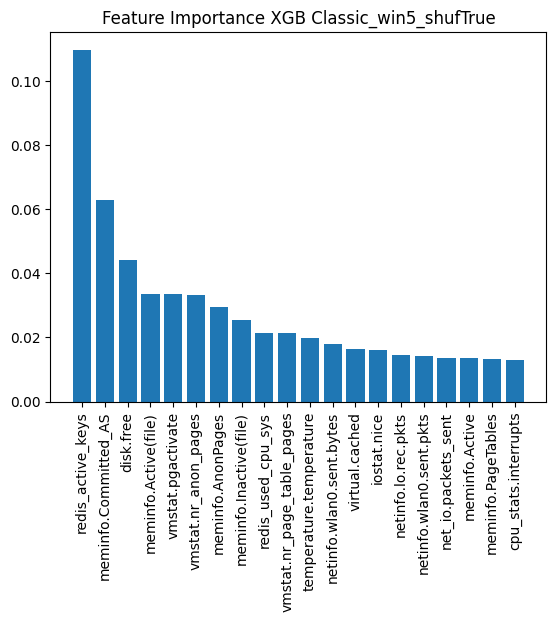

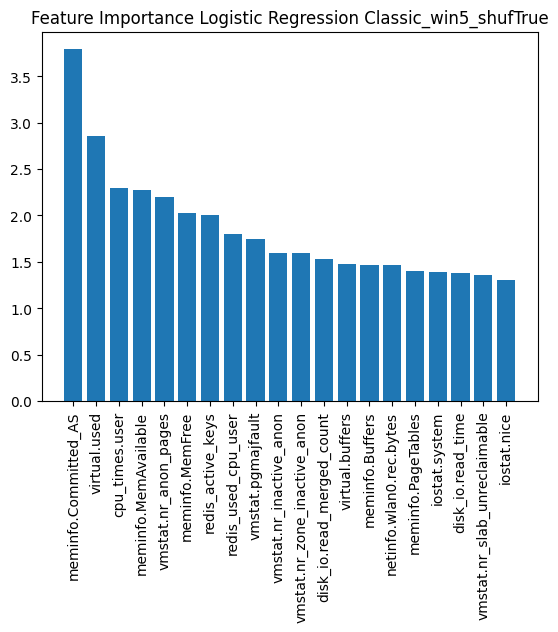

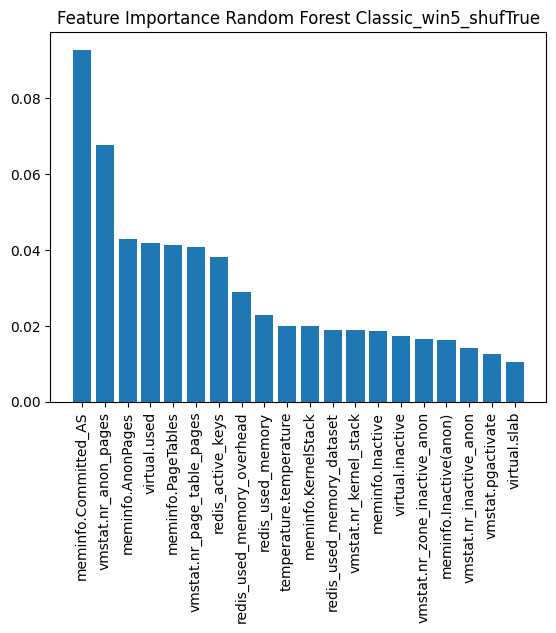

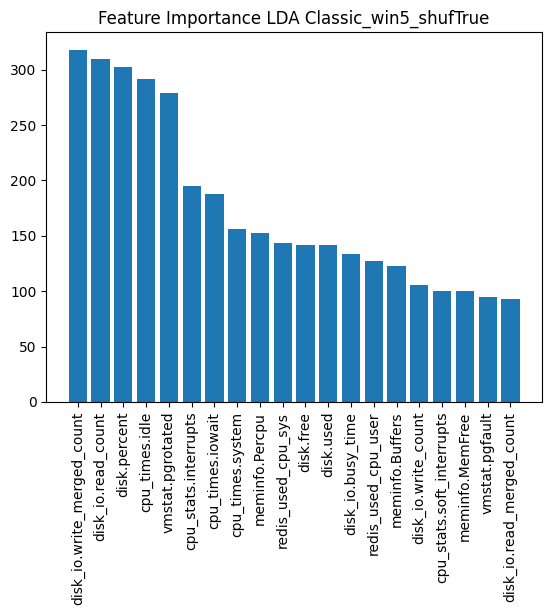

/var/folders/cs/nppv29k17nddrvw_mb475kjc0000gn/T/ipykernel_20145/3785871646.py:8: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  df[f'{x}_{i}'] =data[f'{x}']-data[f'{x}'].shift(i)


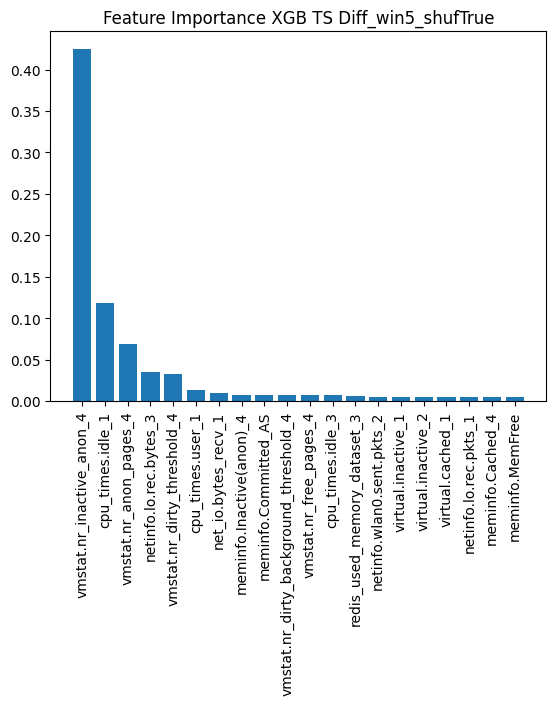

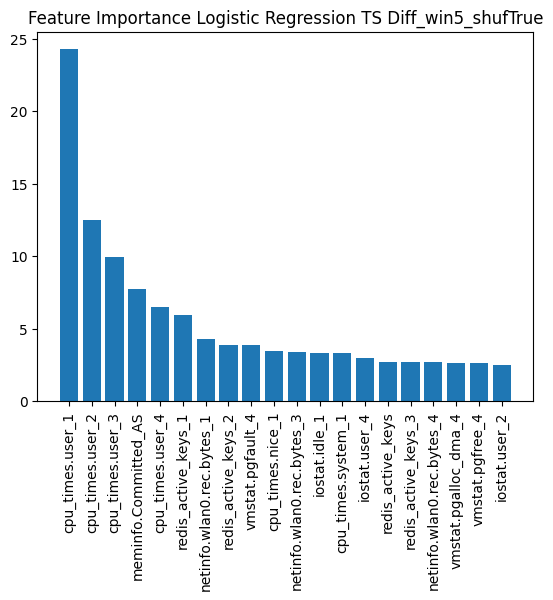

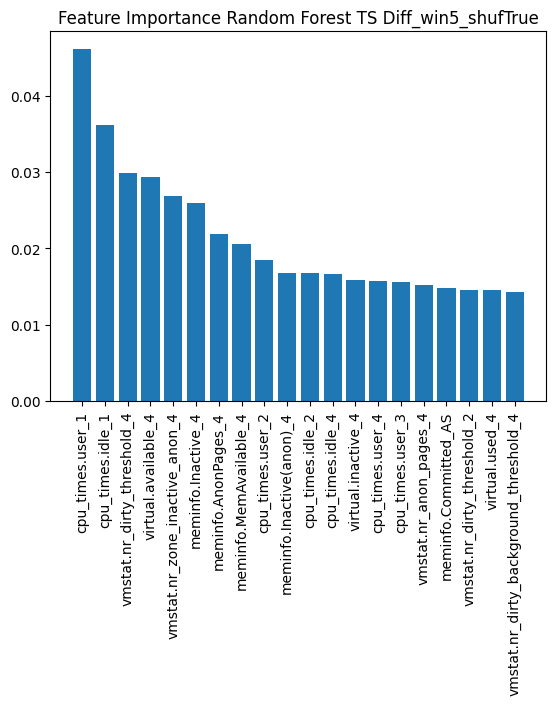

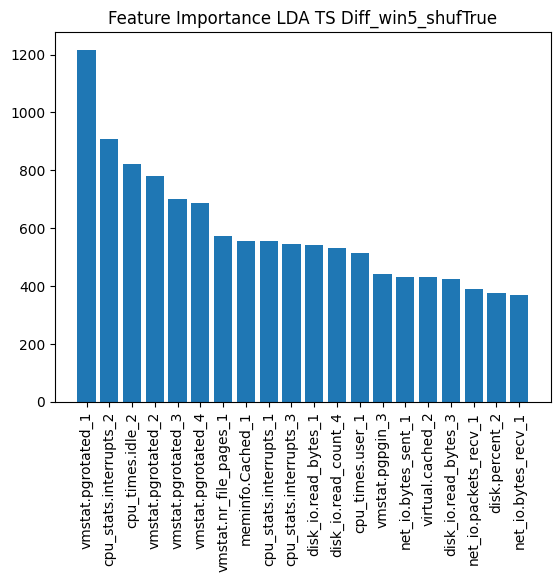

/var/folders/cs/nppv29k17nddrvw_mb475kjc0000gn/T/ipykernel_20145/2262210672.py:6: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  df[f'{x}_ma']=df[f'{x}'].rolling(window_length).mean()
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


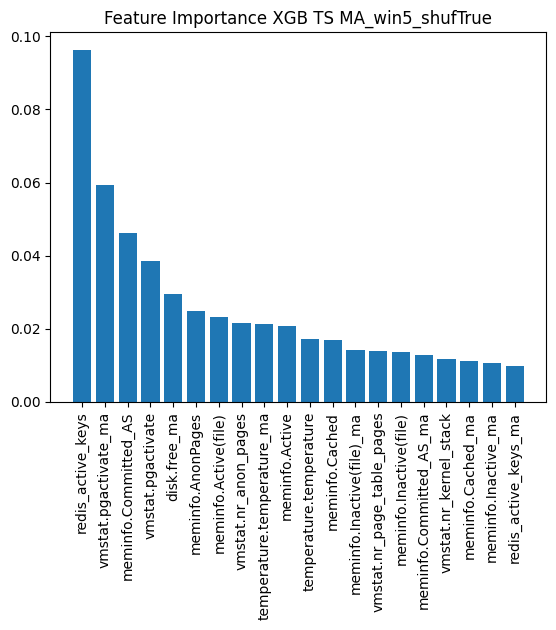

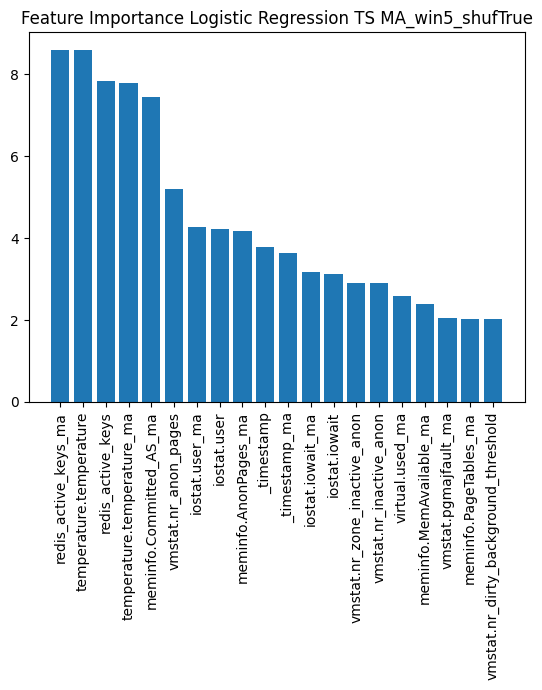

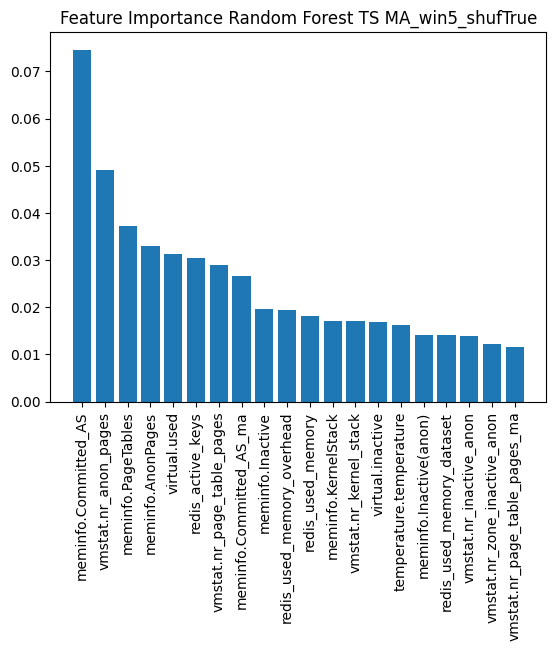

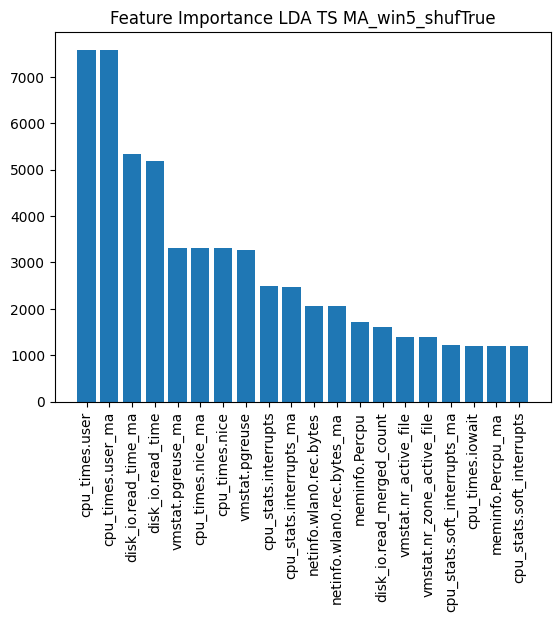

/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/var/folders/cs/nppv29k17nddrvw_mb475kjc0000gn/T/ipykernel_20145/3785871646.py:8: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  df[f'{x}_{i}'] =data[f'{x}']-data[f'{x}'].shift(i)
/var/folders/cs/nppv29k17nddrvw_mb475k

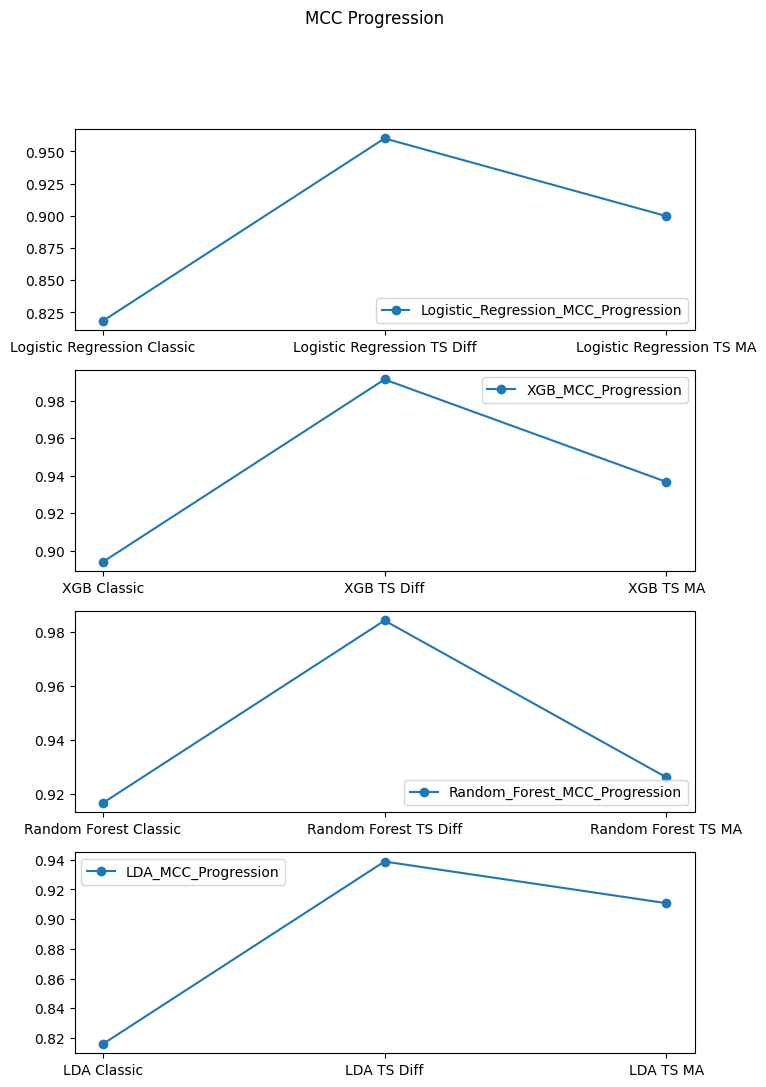

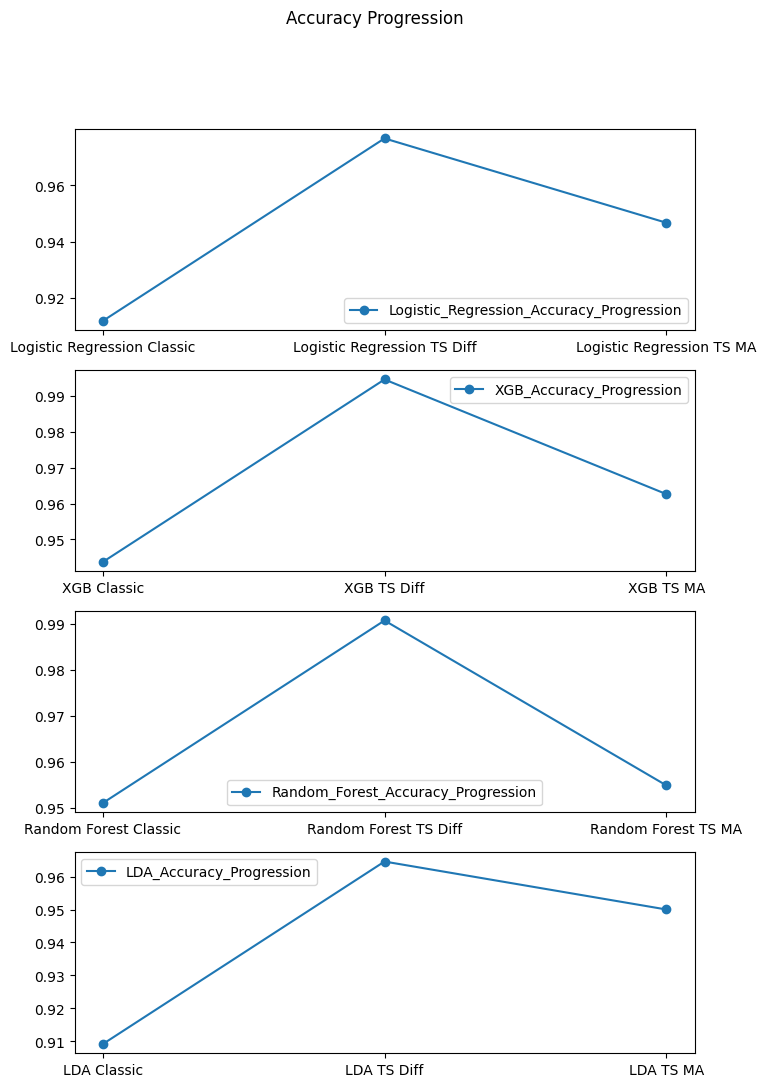

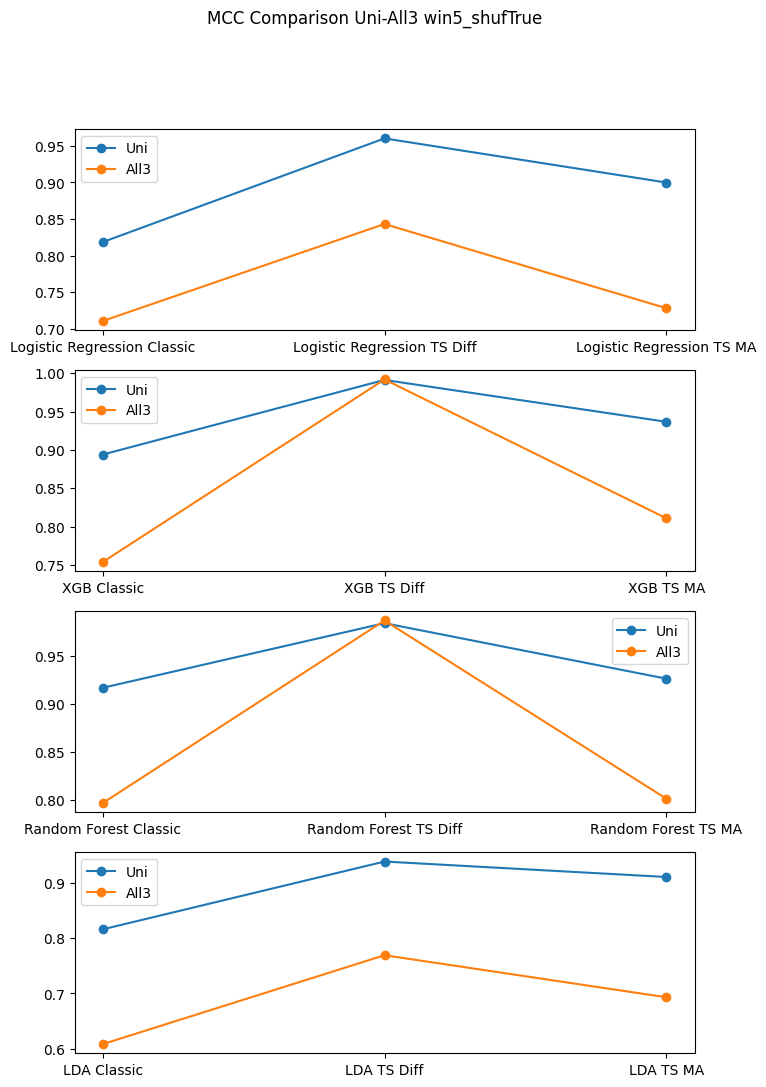

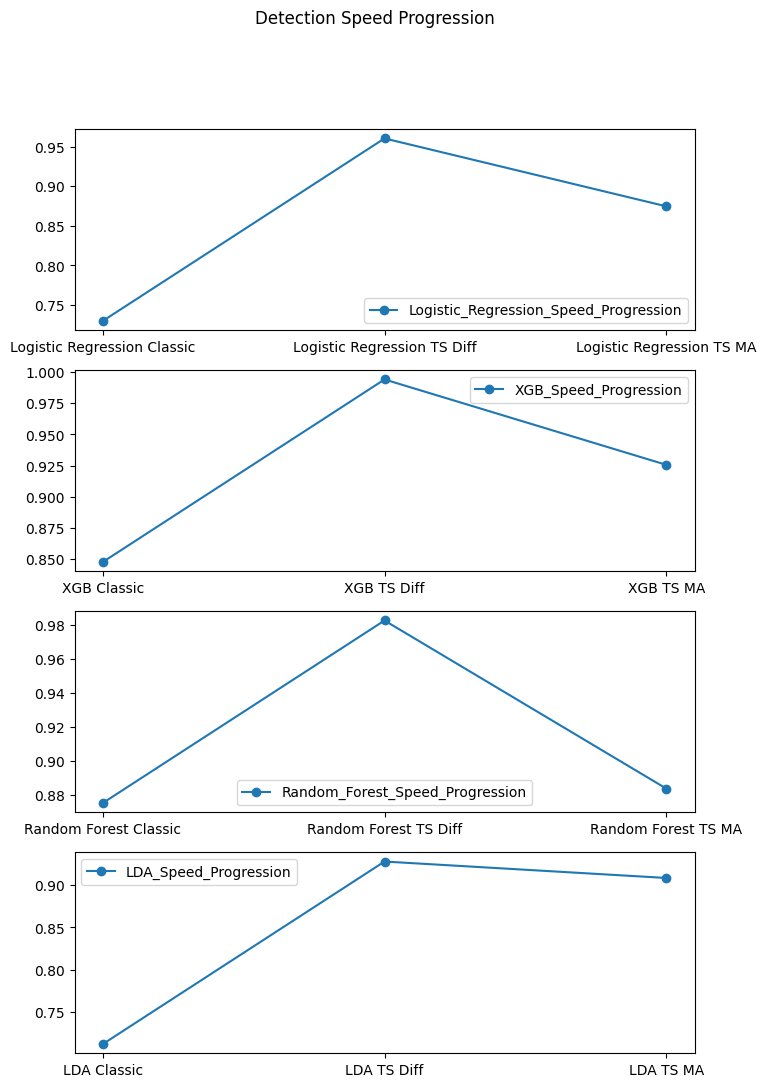

In [78]:
main_1()

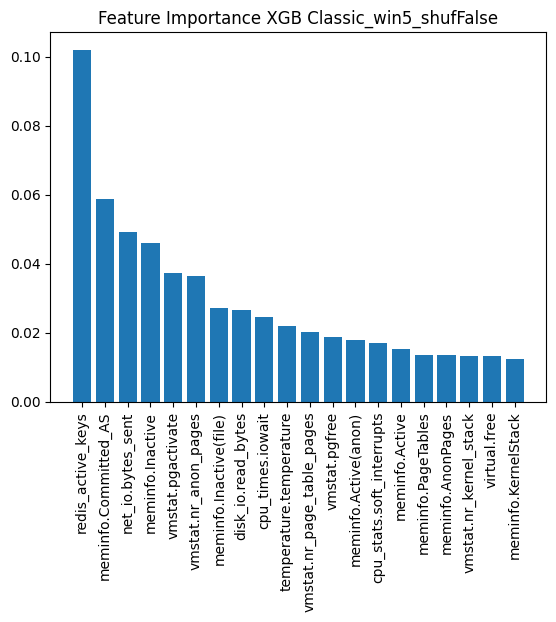

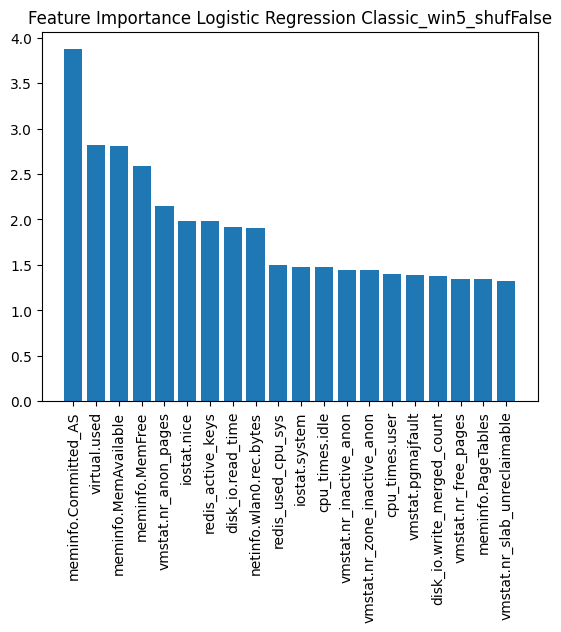

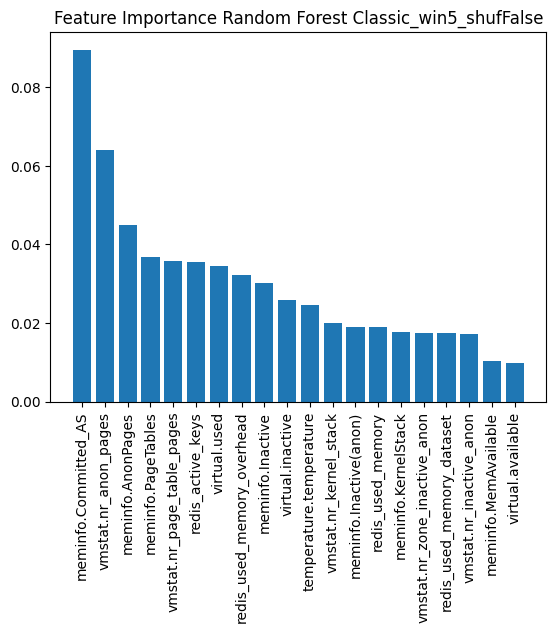

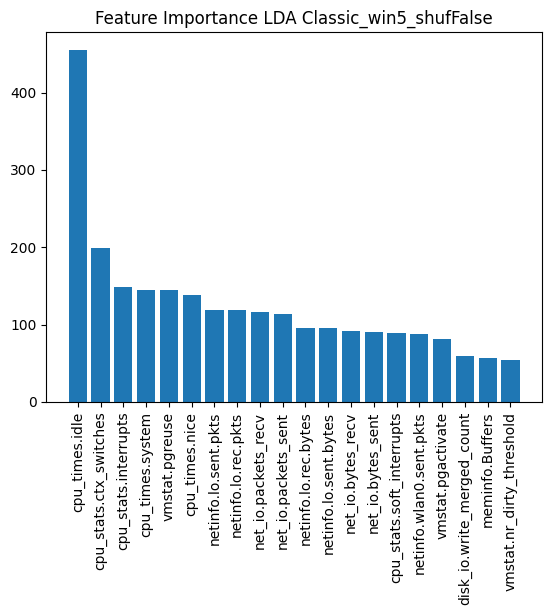

/var/folders/cs/nppv29k17nddrvw_mb475kjc0000gn/T/ipykernel_20145/3785871646.py:8: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  df[f'{x}_{i}'] =data[f'{x}']-data[f'{x}'].shift(i)


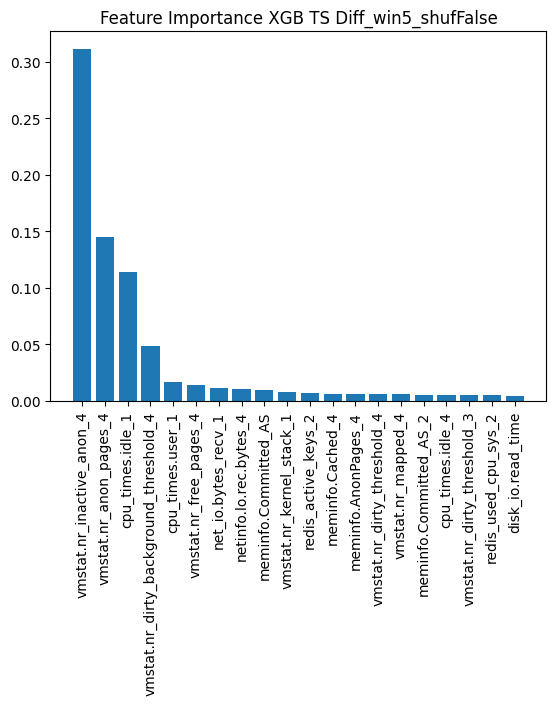

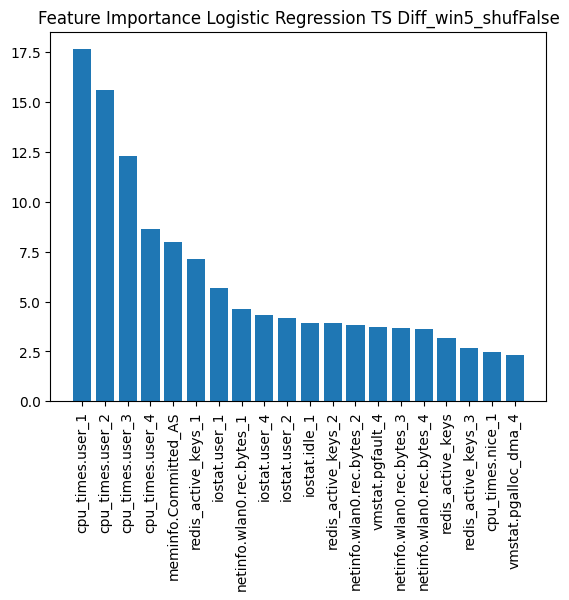

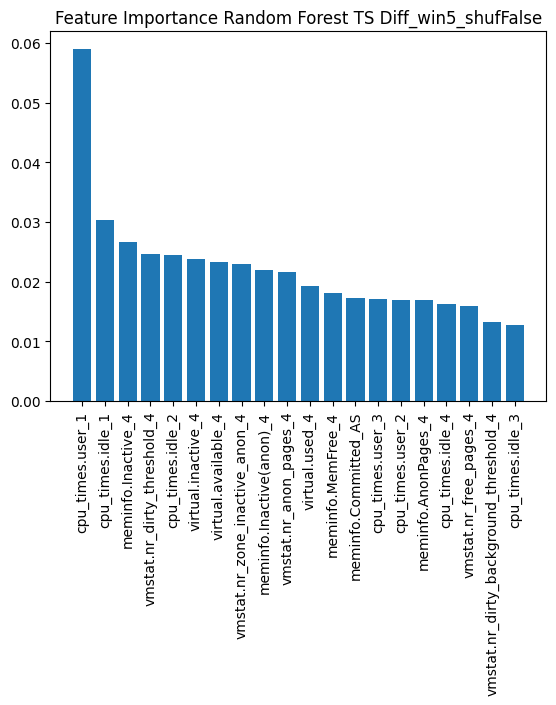

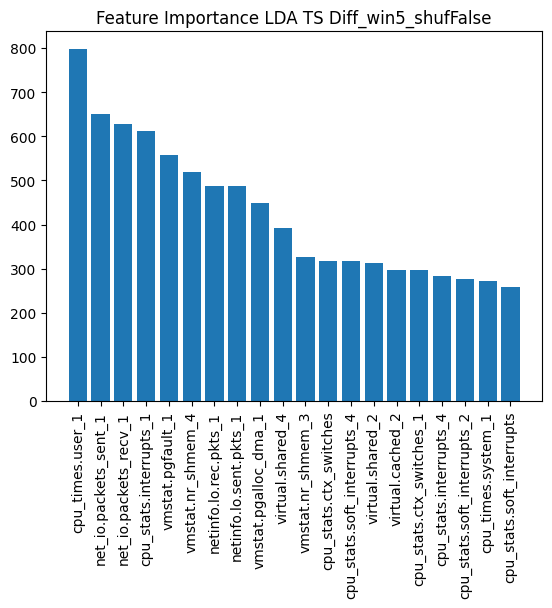

/var/folders/cs/nppv29k17nddrvw_mb475kjc0000gn/T/ipykernel_20145/2262210672.py:6: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  df[f'{x}_ma']=df[f'{x}'].rolling(window_length).mean()
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


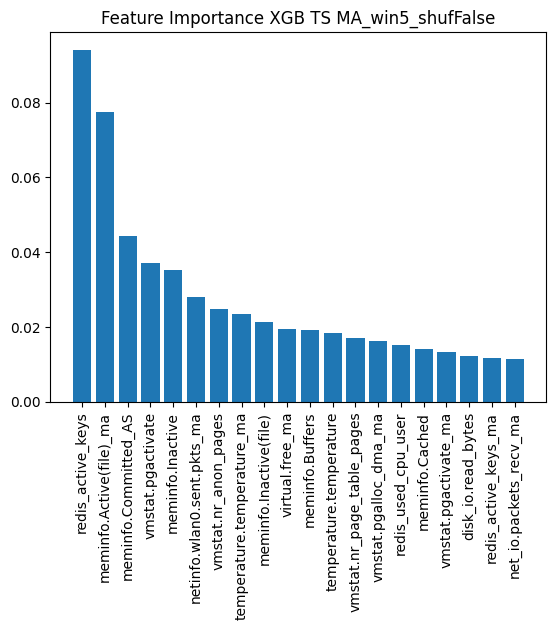

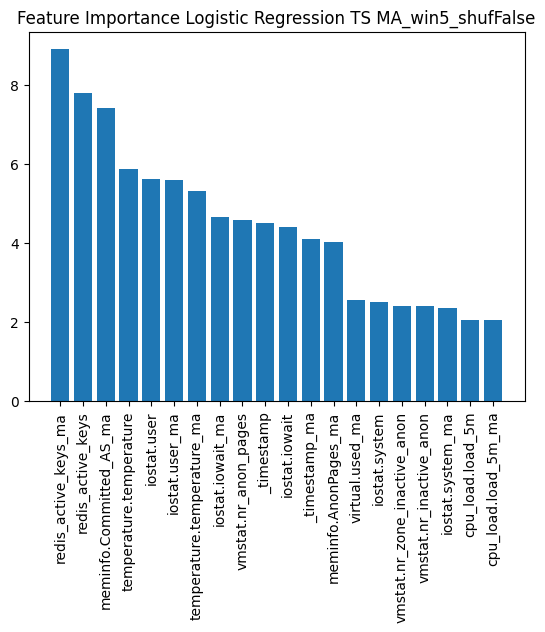

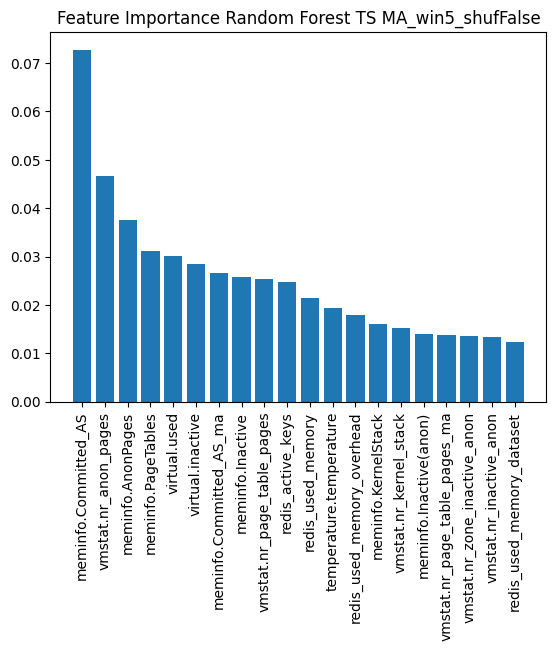

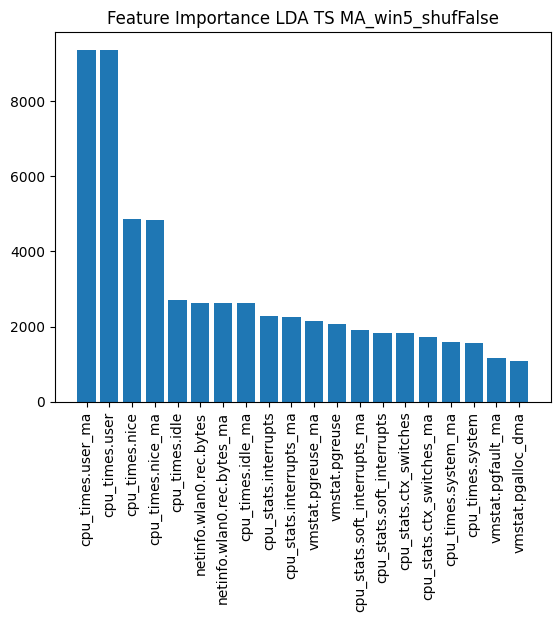

/var/folders/cs/nppv29k17nddrvw_mb475kjc0000gn/T/ipykernel_20145/3785871646.py:8: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  df[f'{x}_{i}'] =data[f'{x}']-data[f'{x}'].shift(i)
/var/folders/cs/nppv29k17nddrvw_mb475kjc0000gn/T/ipykernel_20145/2262210672.py:6: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  df[f'{x}_ma']=df[f'{x}'].rolling(window_length).mean()


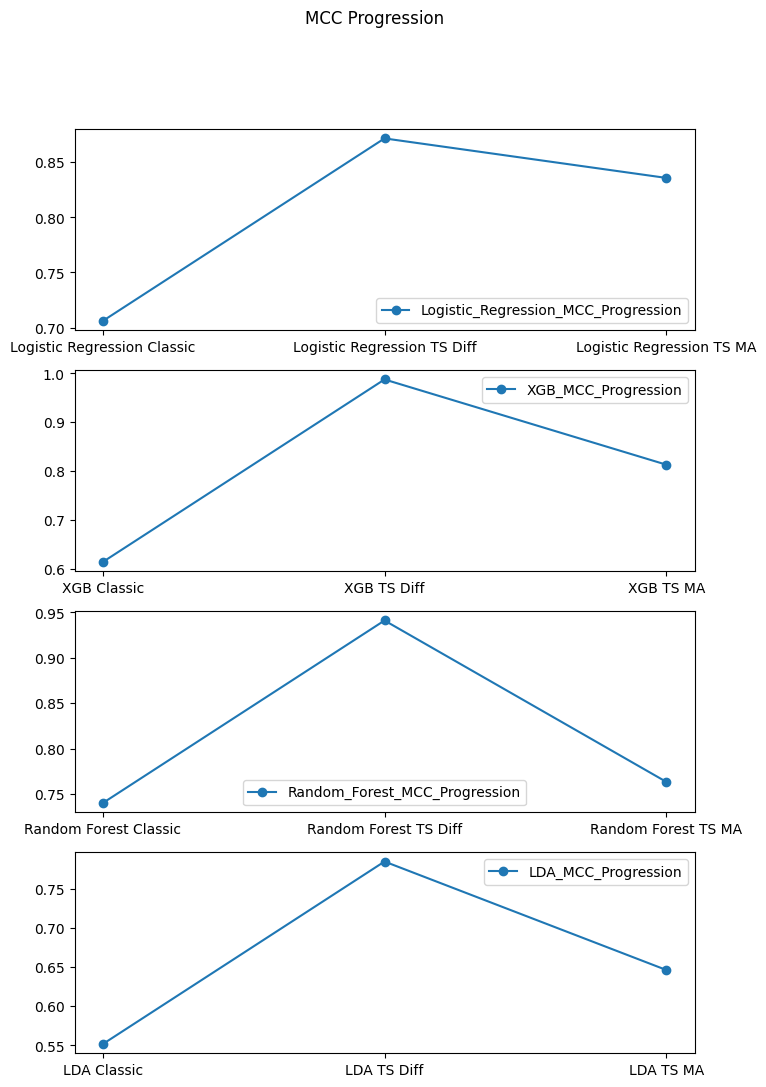

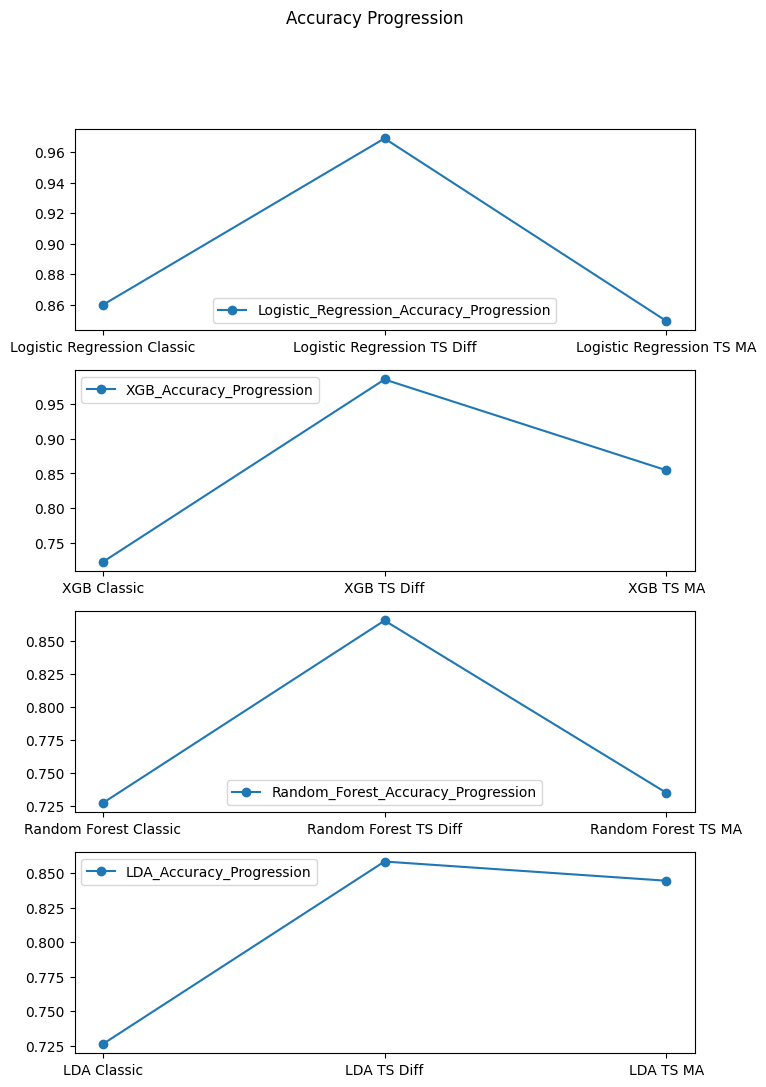

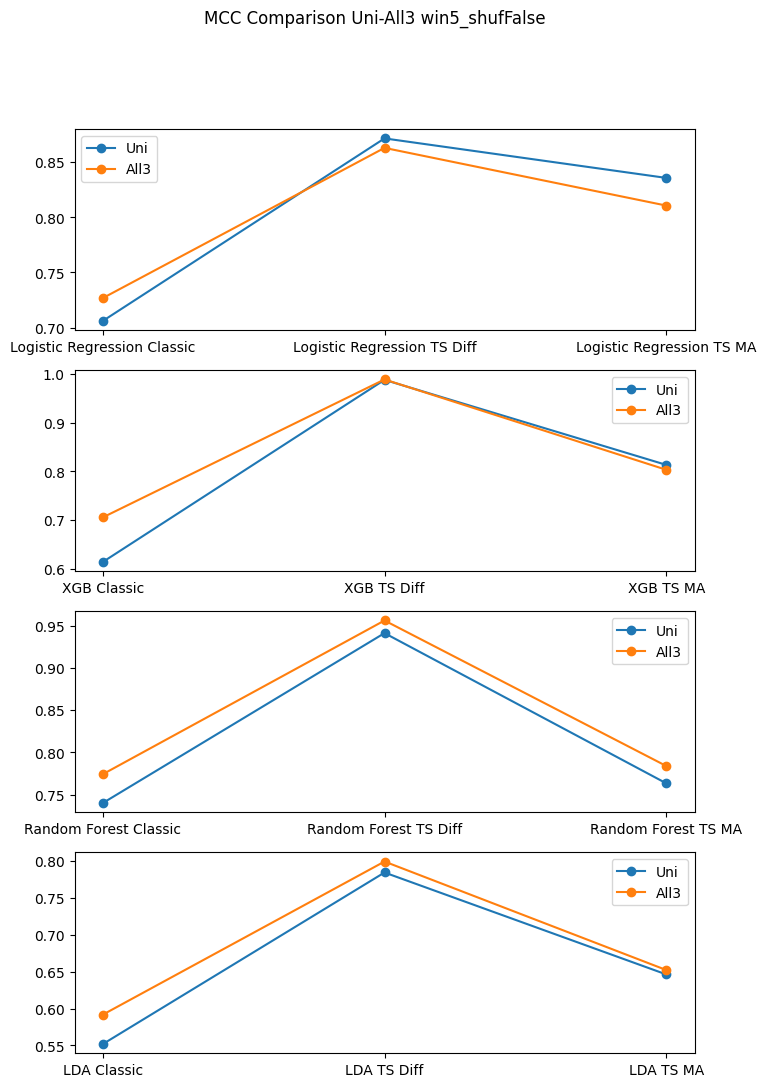

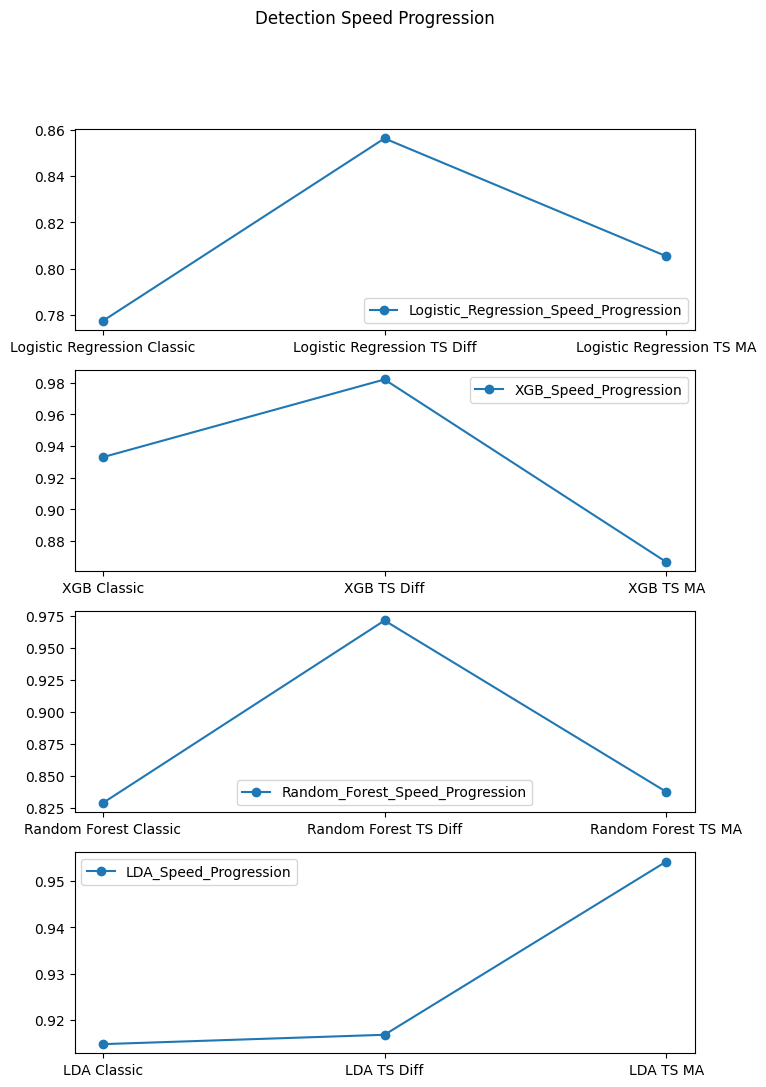

In [79]:
main_2()

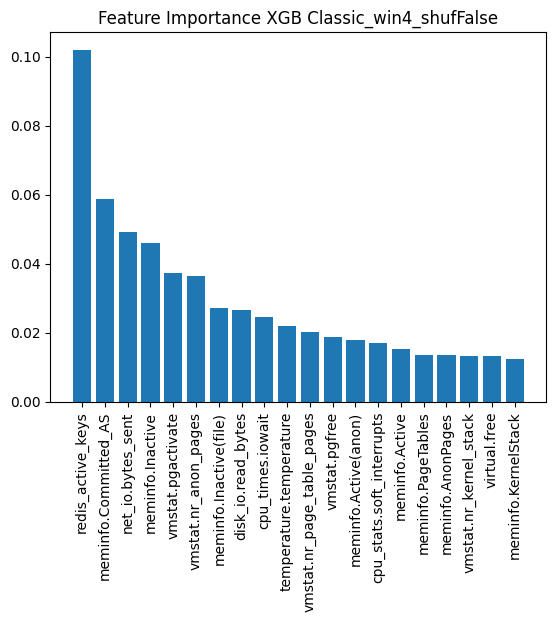

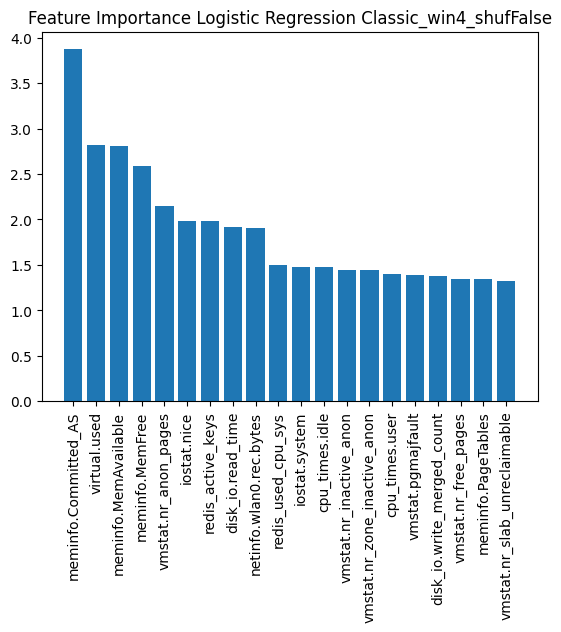

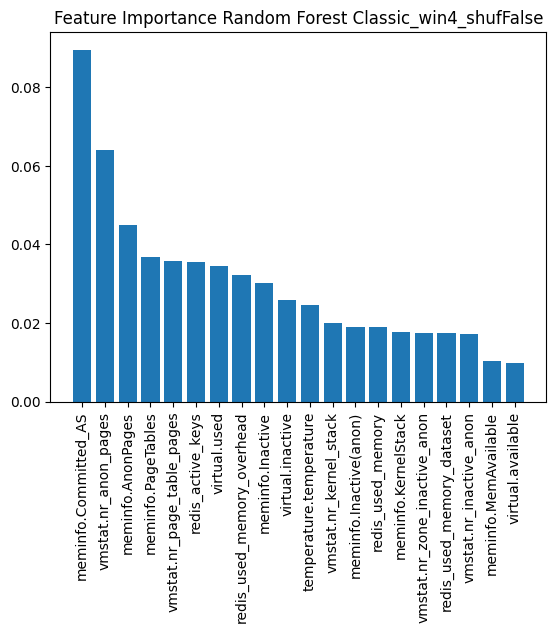

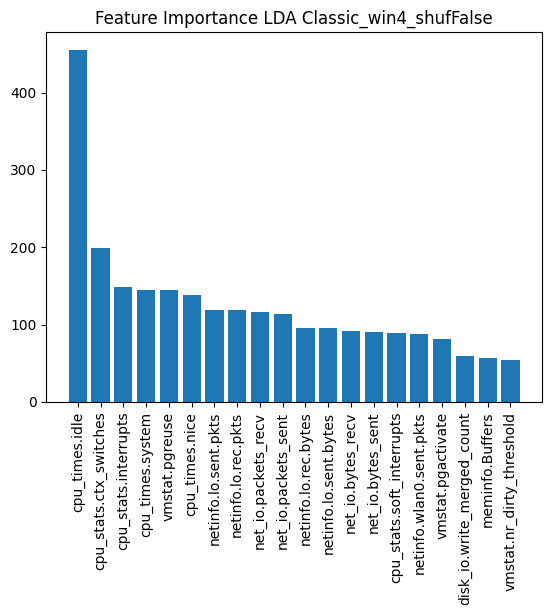

/var/folders/cs/nppv29k17nddrvw_mb475kjc0000gn/T/ipykernel_20145/3785871646.py:8: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  df[f'{x}_{i}'] =data[f'{x}']-data[f'{x}'].shift(i)


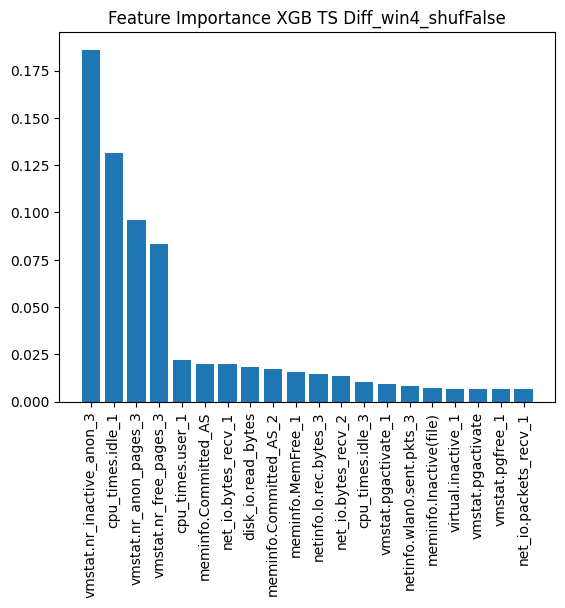

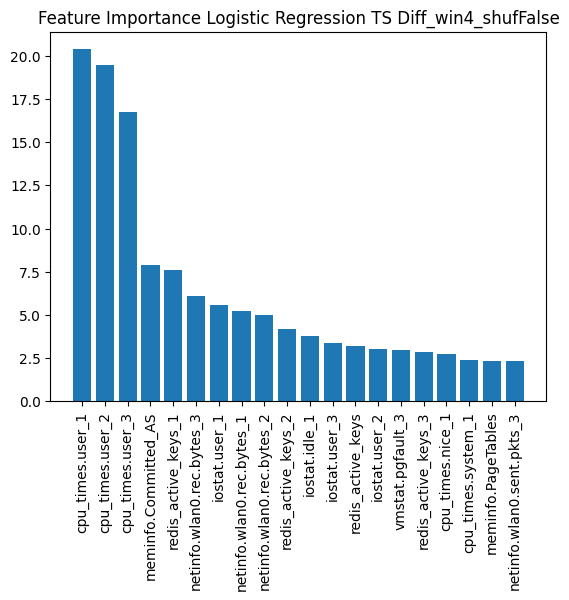

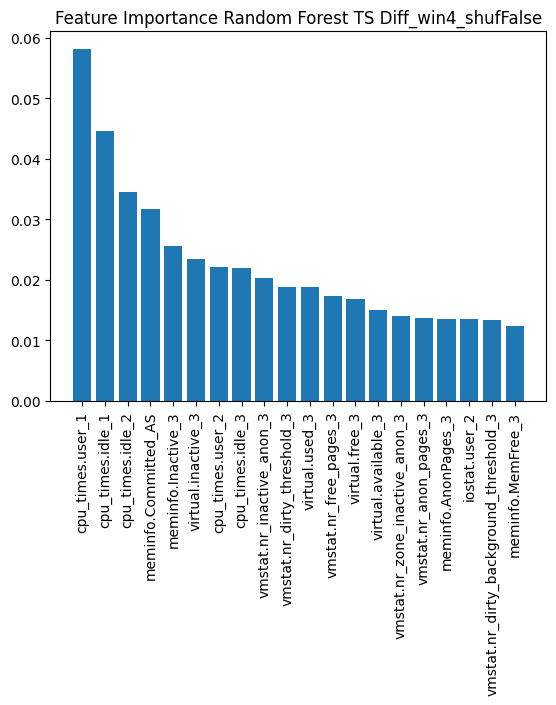

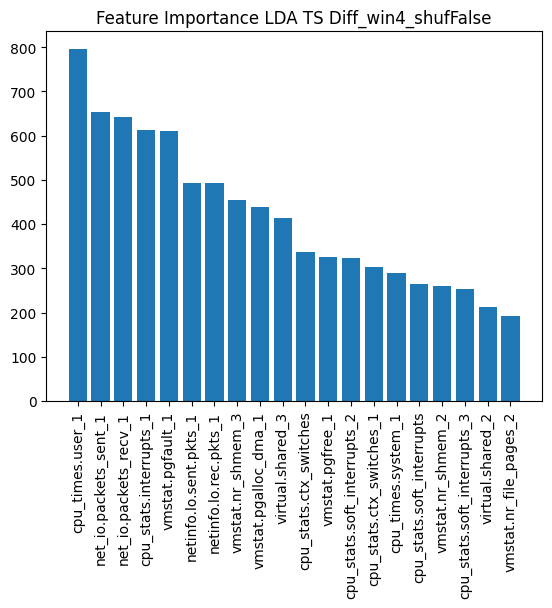

/var/folders/cs/nppv29k17nddrvw_mb475kjc0000gn/T/ipykernel_20145/2262210672.py:6: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  df[f'{x}_ma']=df[f'{x}'].rolling(window_length).mean()


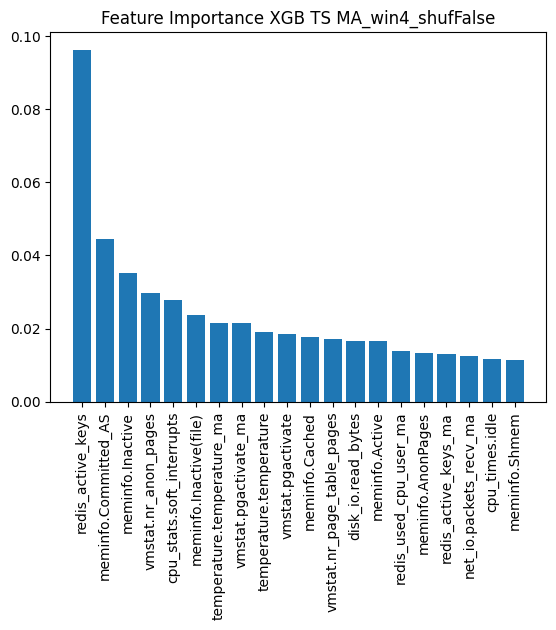

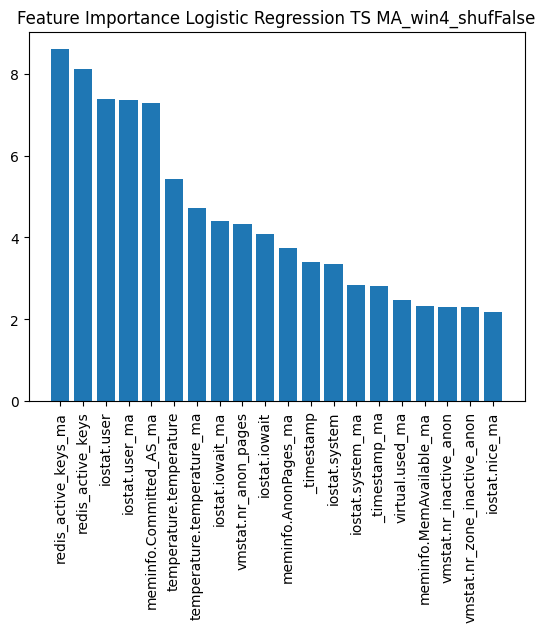

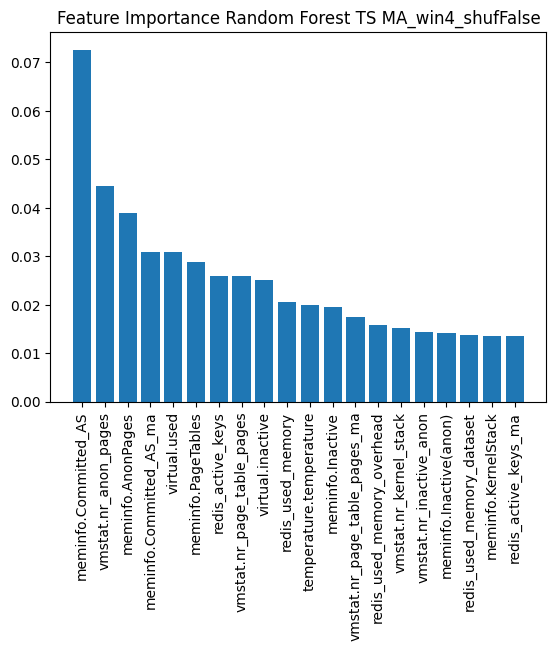

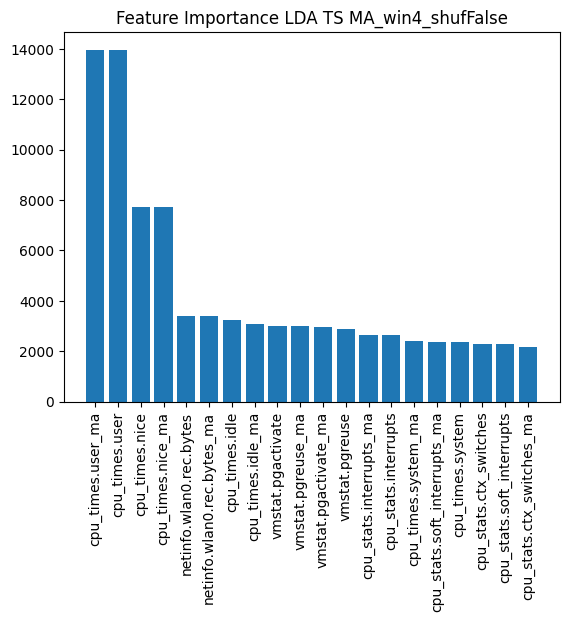

/var/folders/cs/nppv29k17nddrvw_mb475kjc0000gn/T/ipykernel_20145/3785871646.py:8: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  df[f'{x}_{i}'] =data[f'{x}']-data[f'{x}'].shift(i)
/var/folders/cs/nppv29k17nddrvw_mb475kjc0000gn/T/ipykernel_20145/2262210672.py:6: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  df[f'{x}_ma']=df[f'{x}'].rolling(window_length).mean()


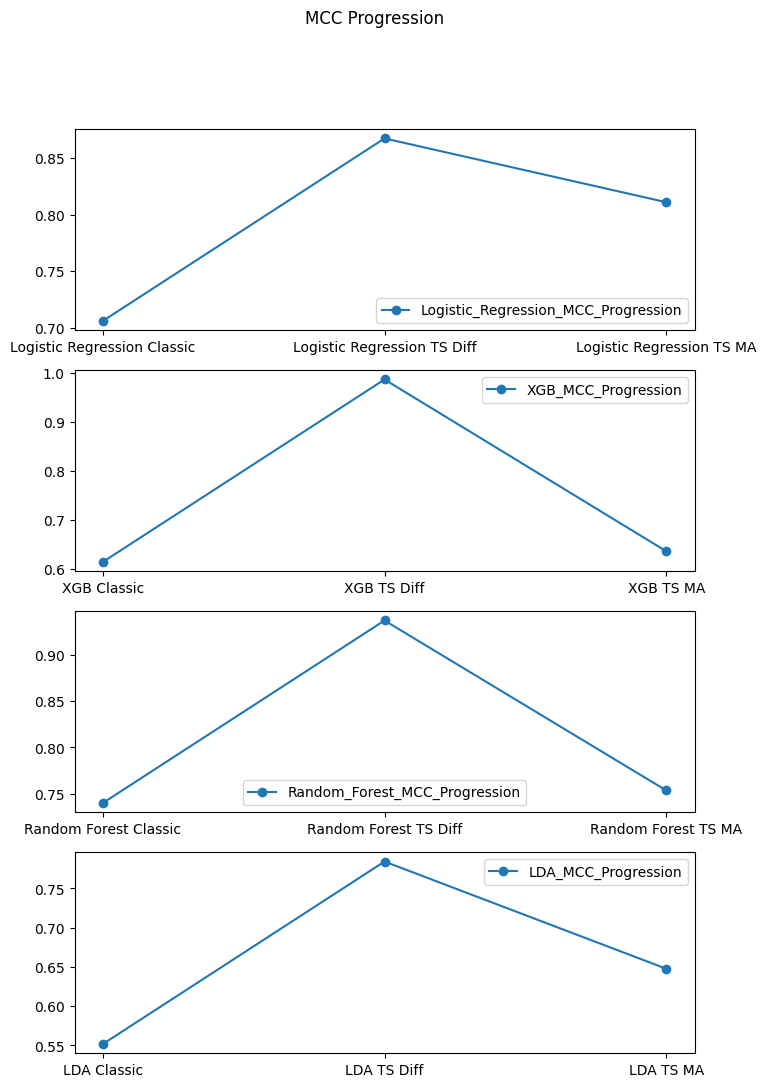

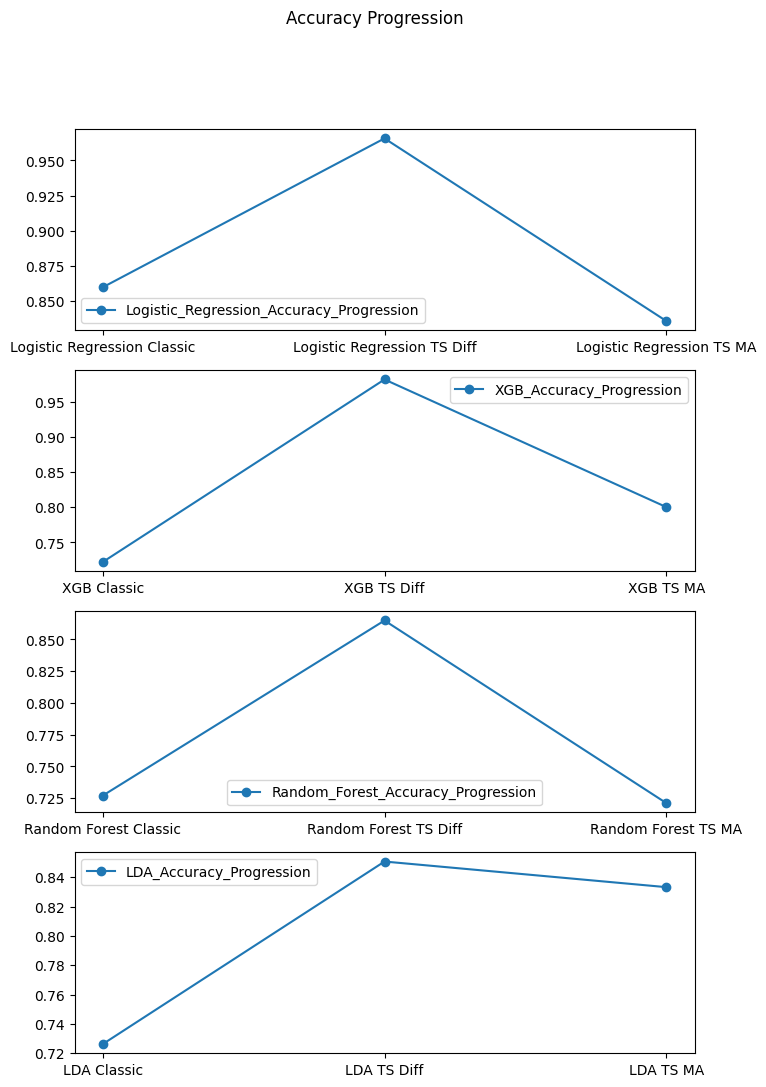

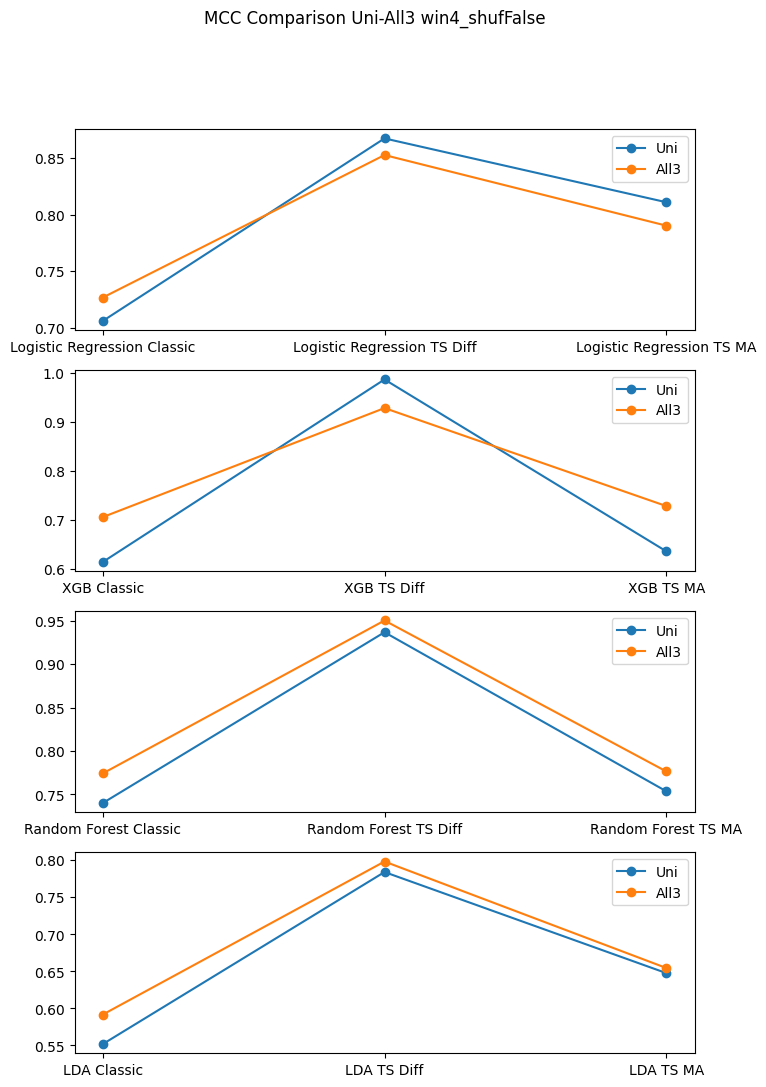

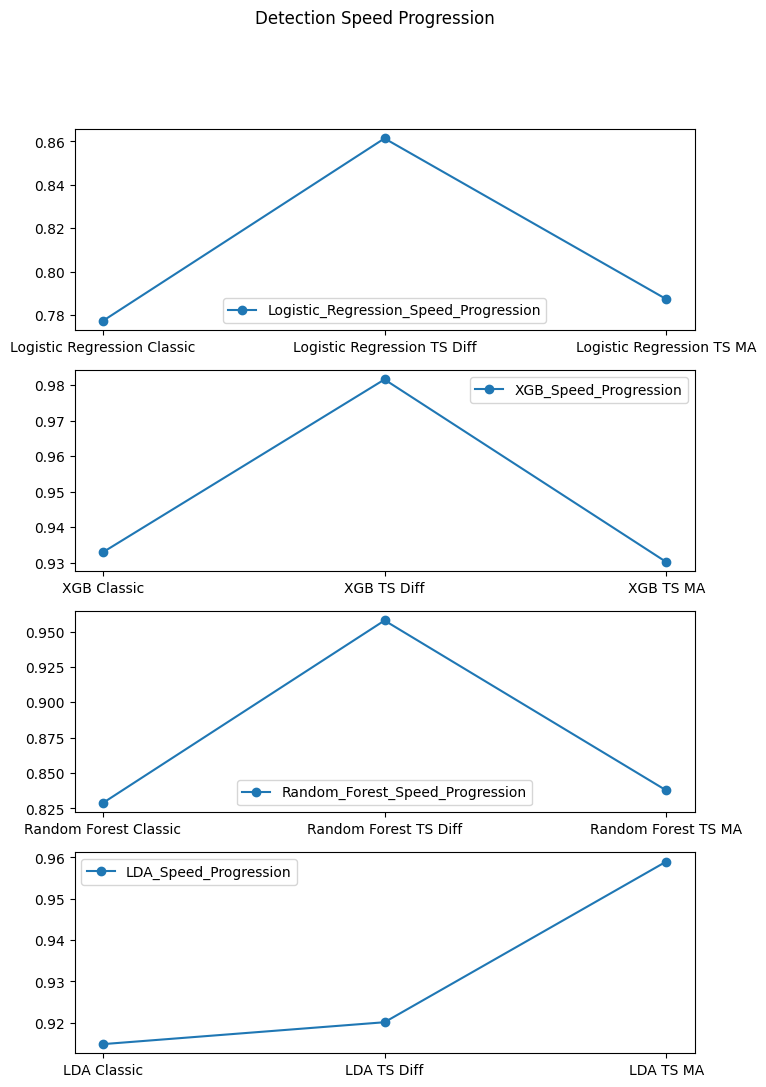

In [80]:
main_3()

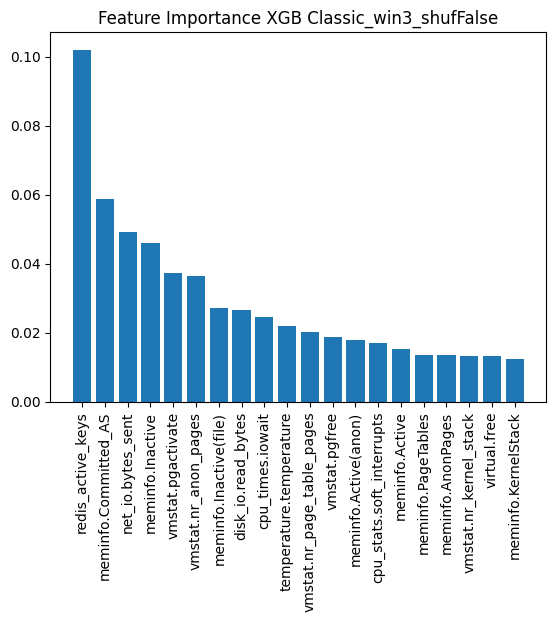

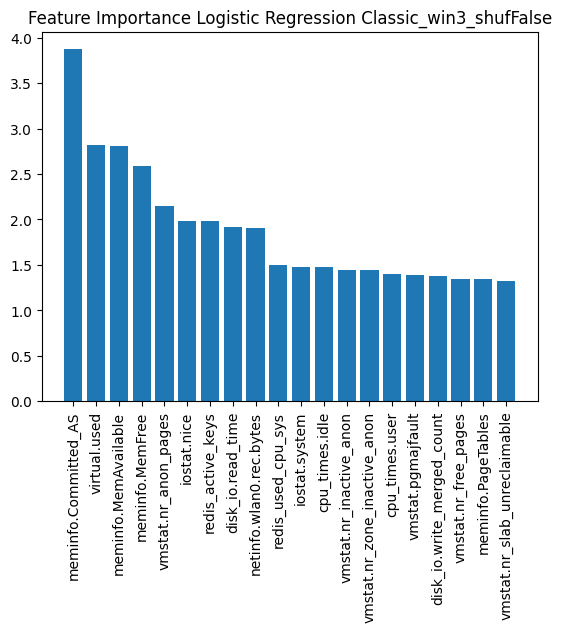

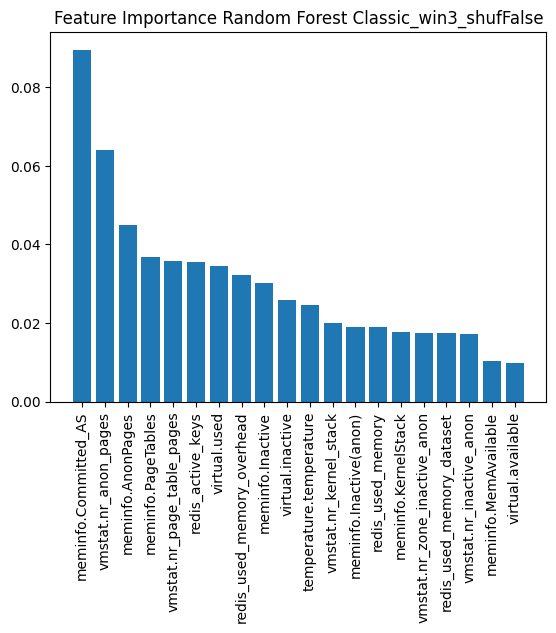

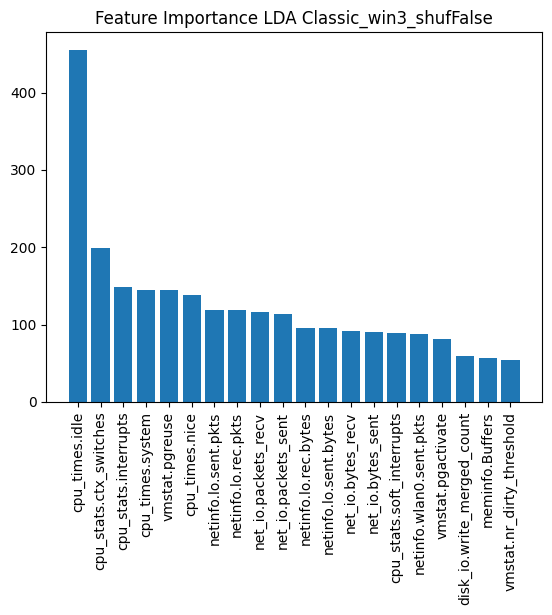

/var/folders/cs/nppv29k17nddrvw_mb475kjc0000gn/T/ipykernel_20145/3785871646.py:8: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  df[f'{x}_{i}'] =data[f'{x}']-data[f'{x}'].shift(i)


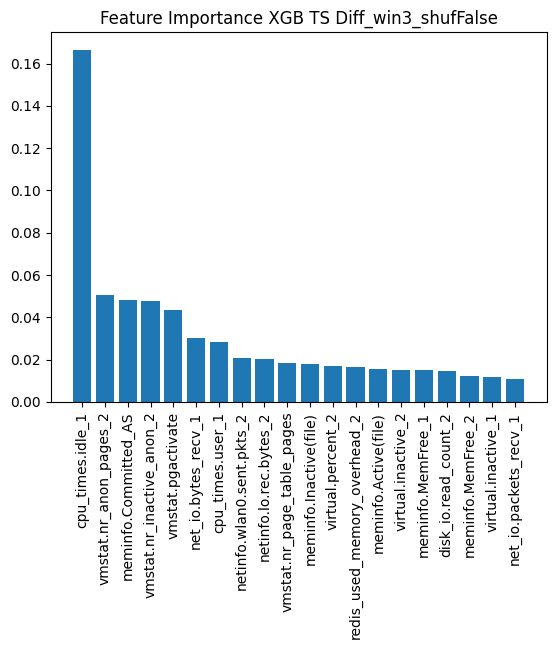

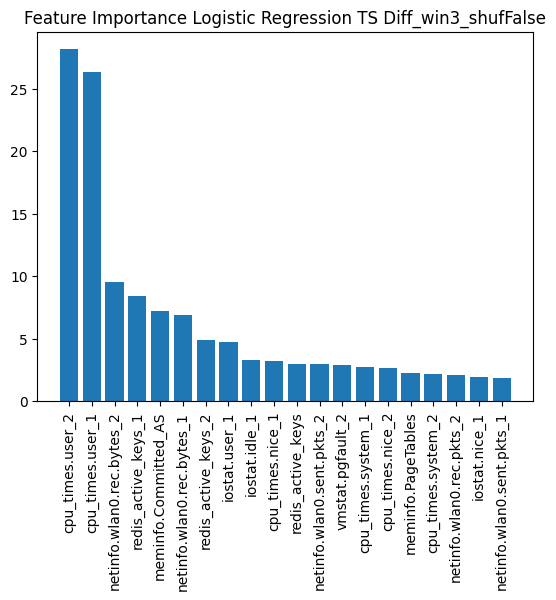

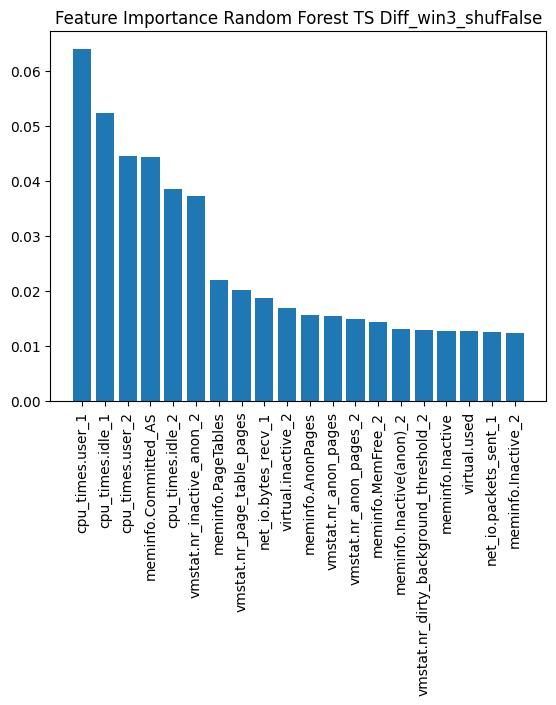

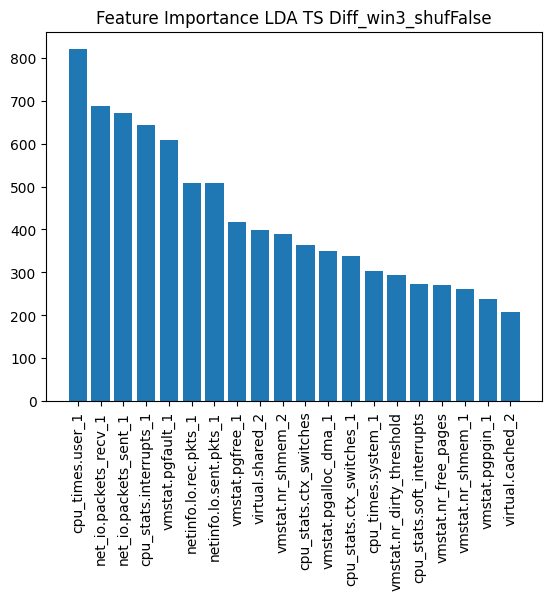

/var/folders/cs/nppv29k17nddrvw_mb475kjc0000gn/T/ipykernel_20145/2262210672.py:6: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  df[f'{x}_ma']=df[f'{x}'].rolling(window_length).mean()


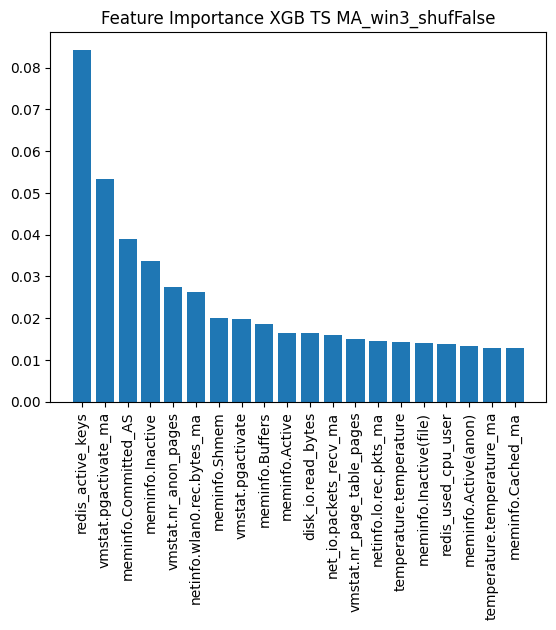

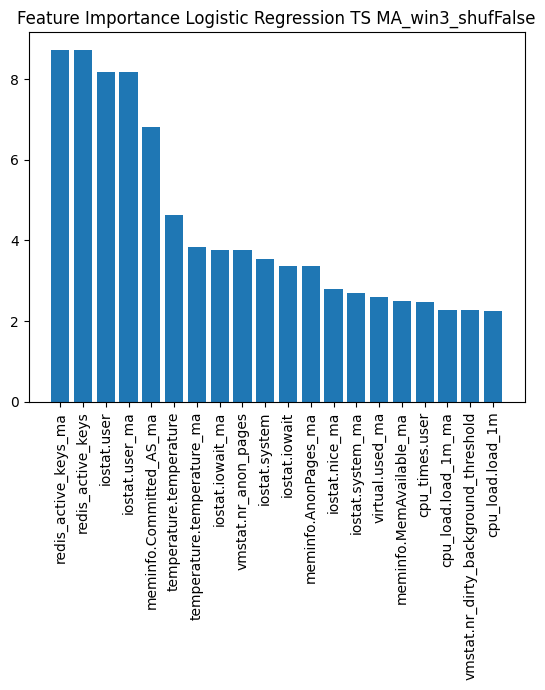

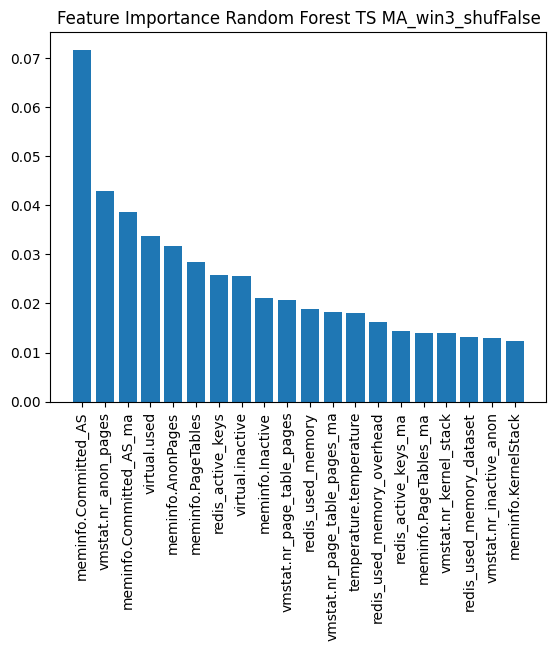

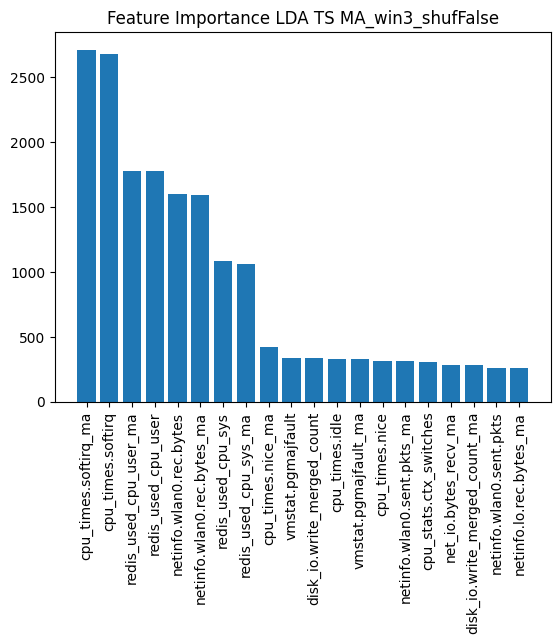

/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/var/folders/cs/nppv29k17nddrvw_mb475kjc0000gn/T/ipykernel_20145/3785871646.py:8: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  df[f'{x}_{i}'] =data[f'{x}']-data[f'{x}'].shift(i)
/var/folders/cs/nppv29k17nddrvw_mb475k

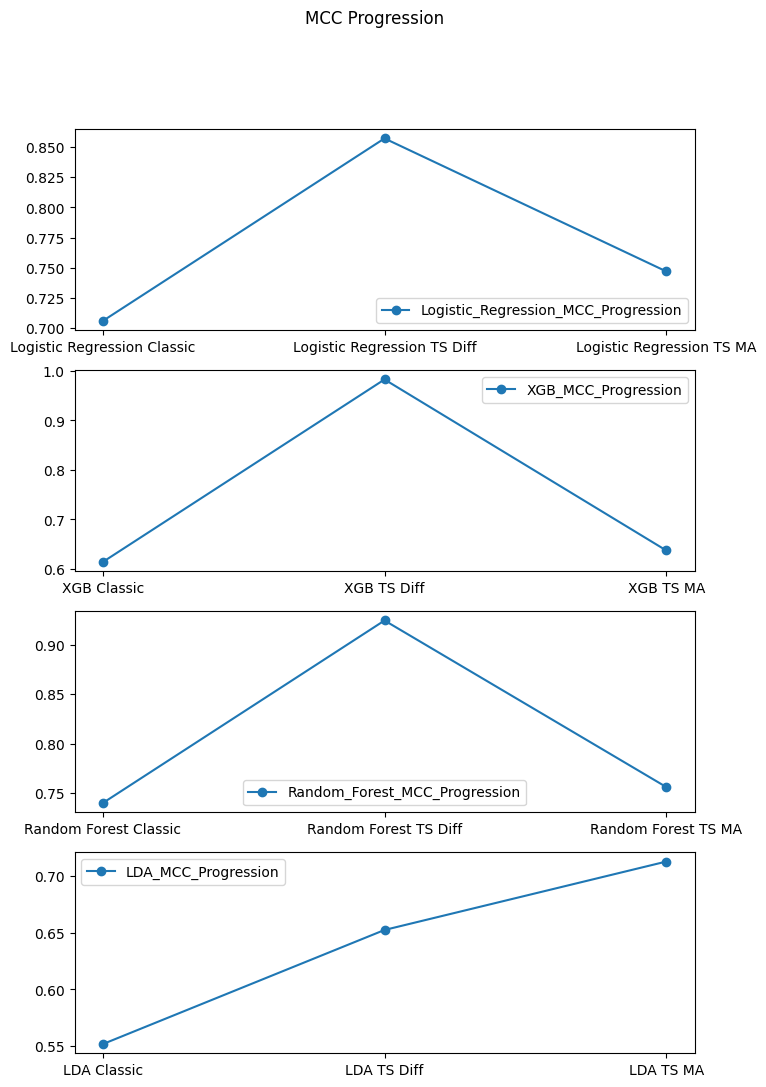

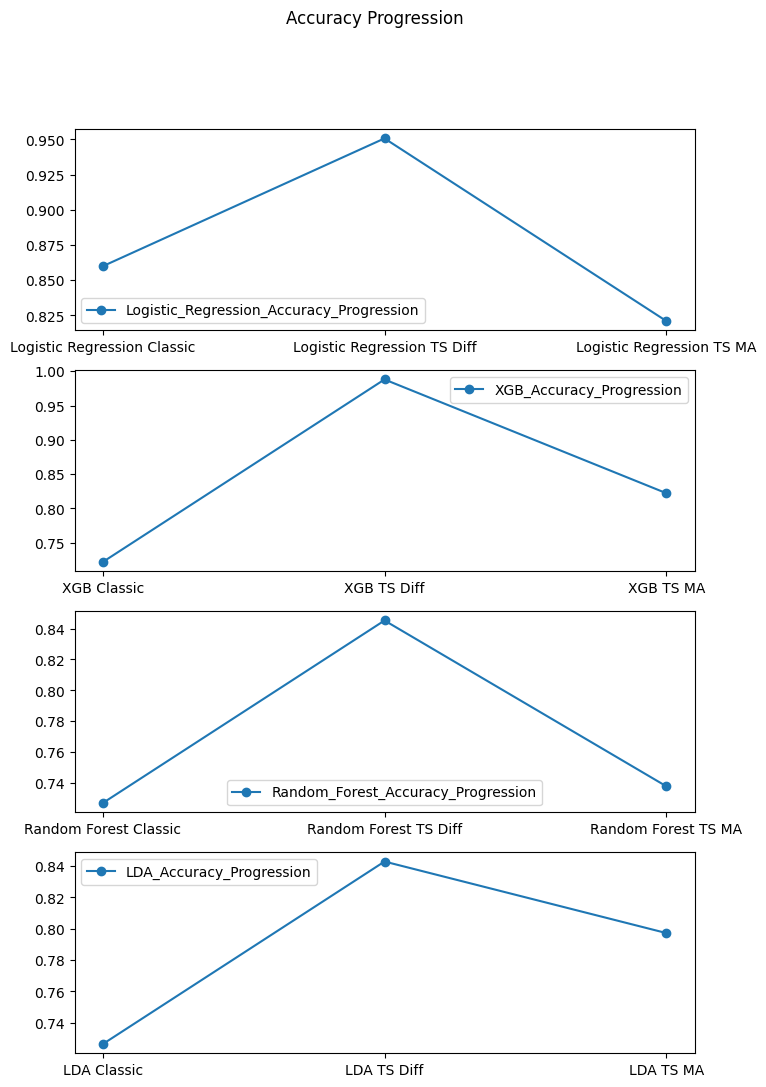

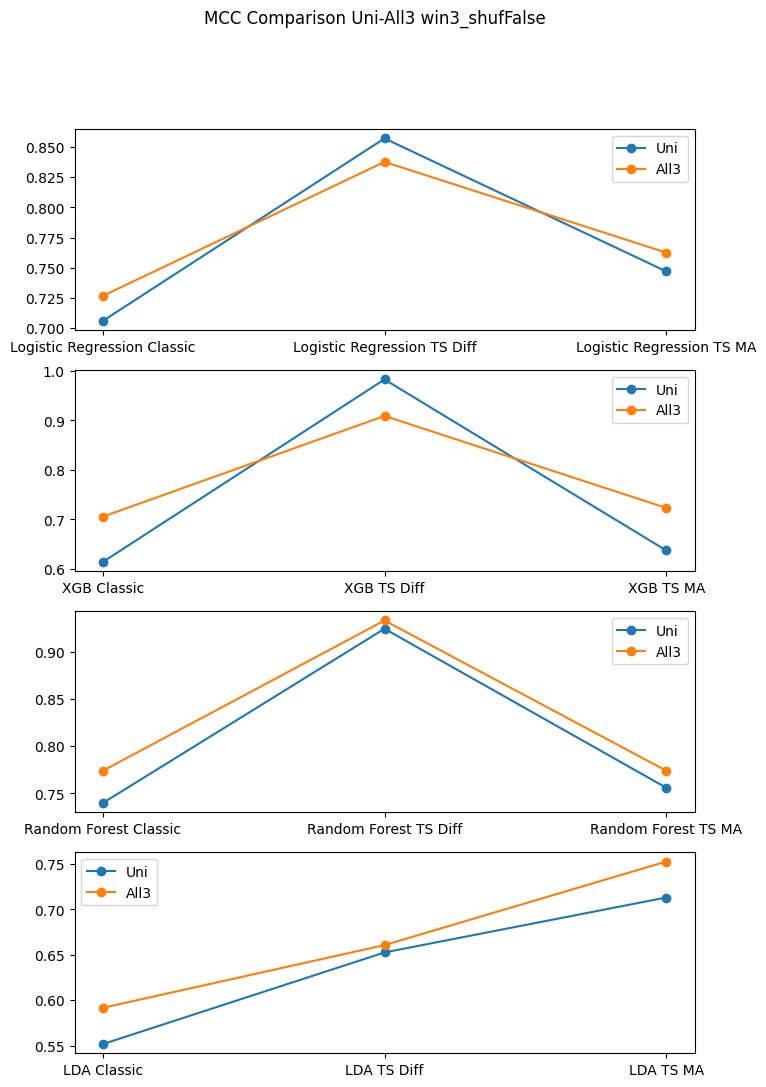

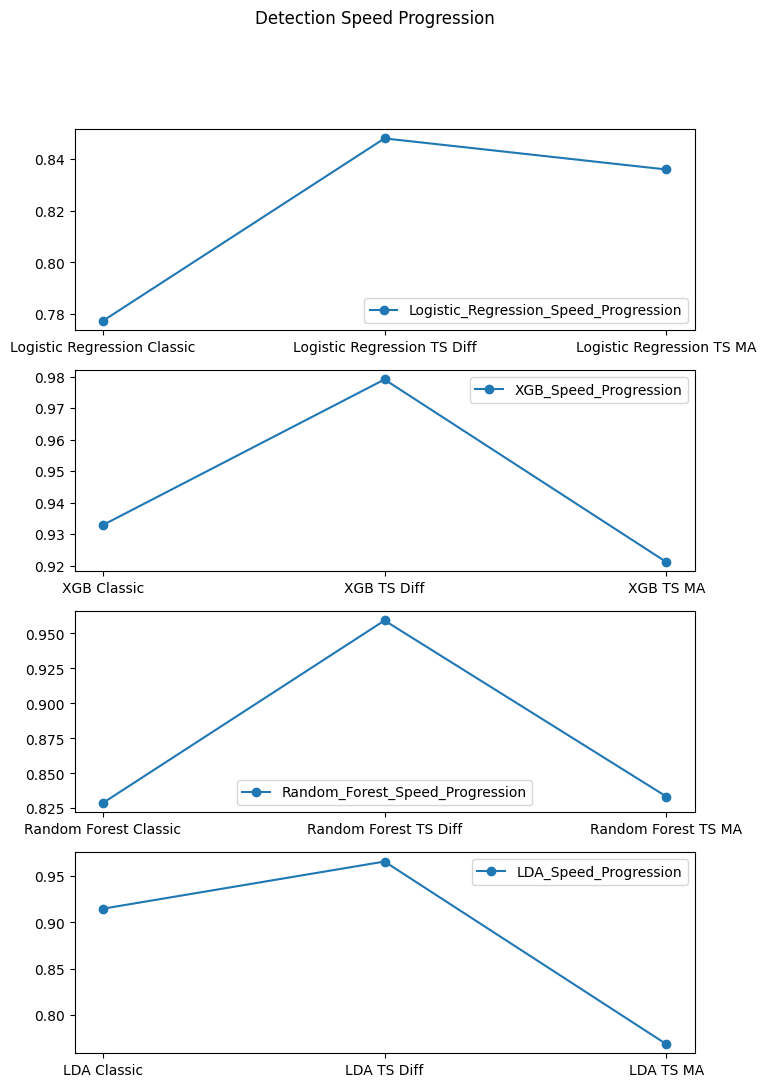

In [81]:
main_4()

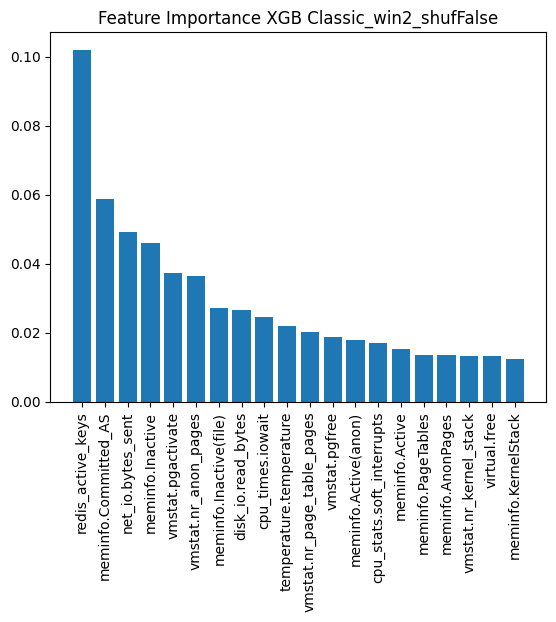

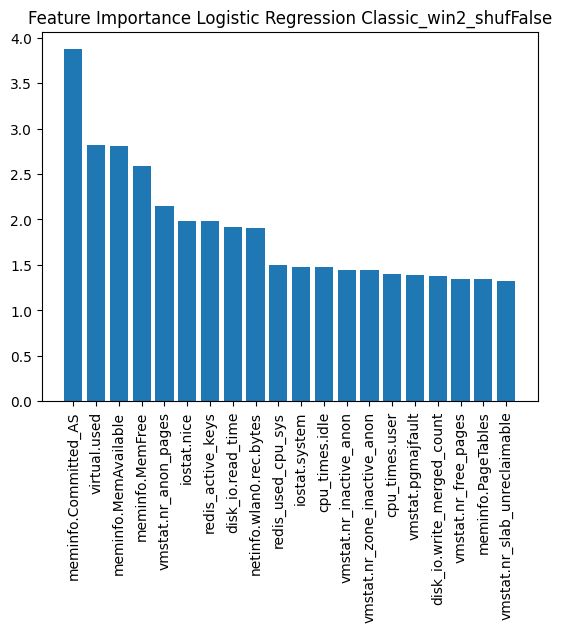

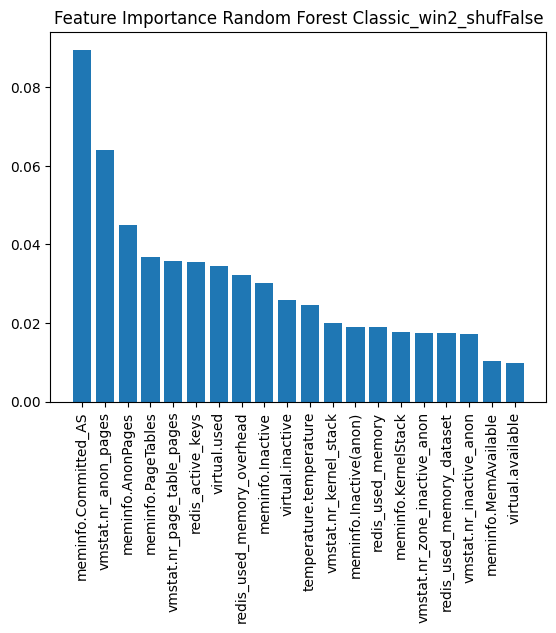

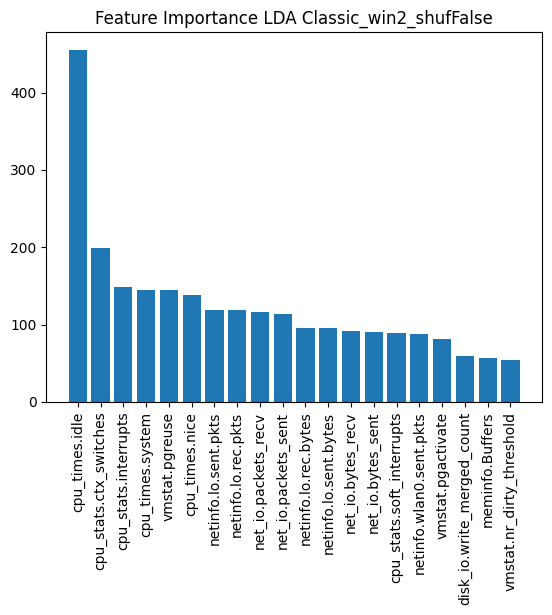

/var/folders/cs/nppv29k17nddrvw_mb475kjc0000gn/T/ipykernel_20145/3785871646.py:8: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  df[f'{x}_{i}'] =data[f'{x}']-data[f'{x}'].shift(i)


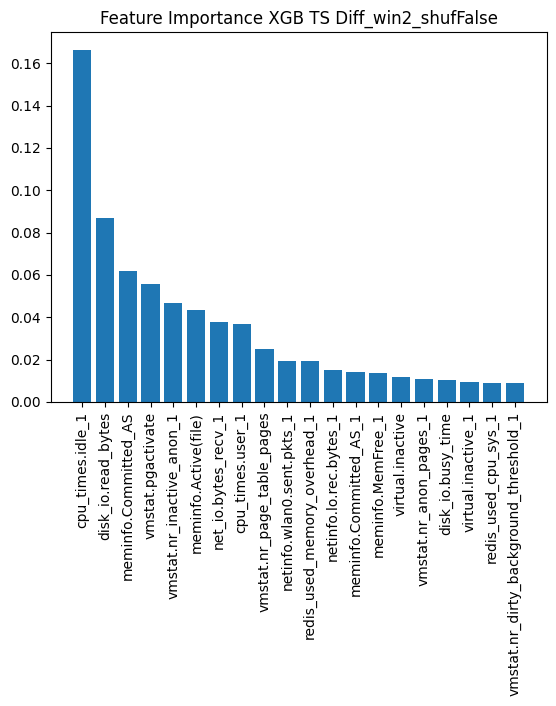

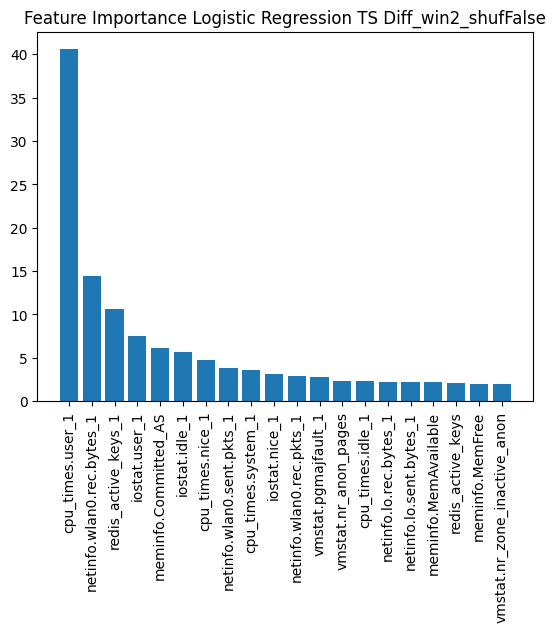

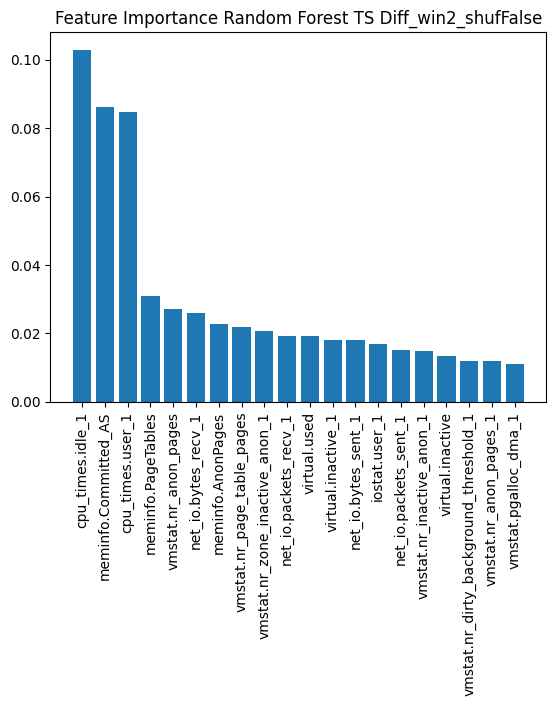

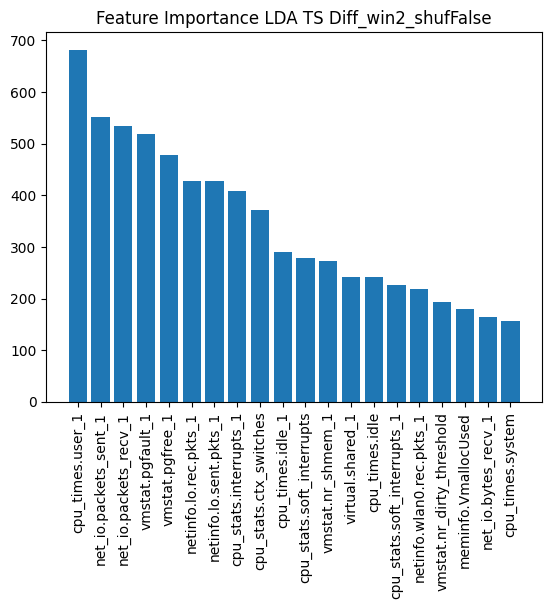

/var/folders/cs/nppv29k17nddrvw_mb475kjc0000gn/T/ipykernel_20145/2262210672.py:6: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  df[f'{x}_ma']=df[f'{x}'].rolling(window_length).mean()
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


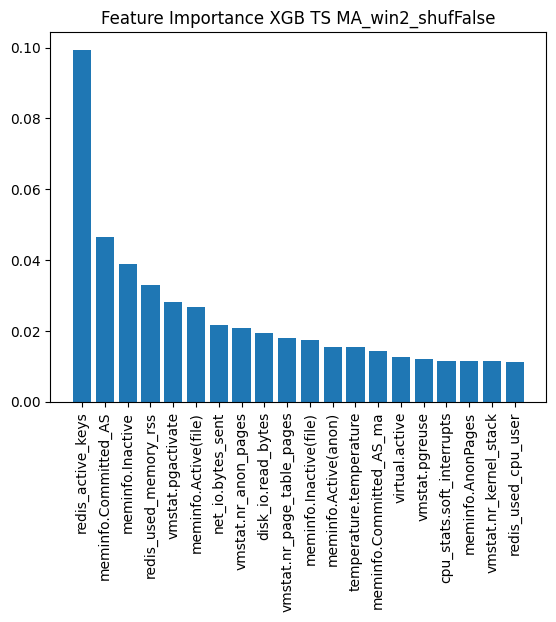

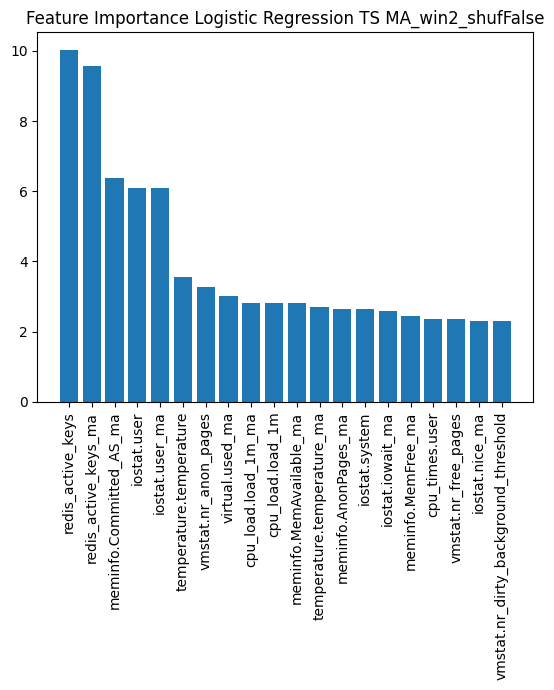

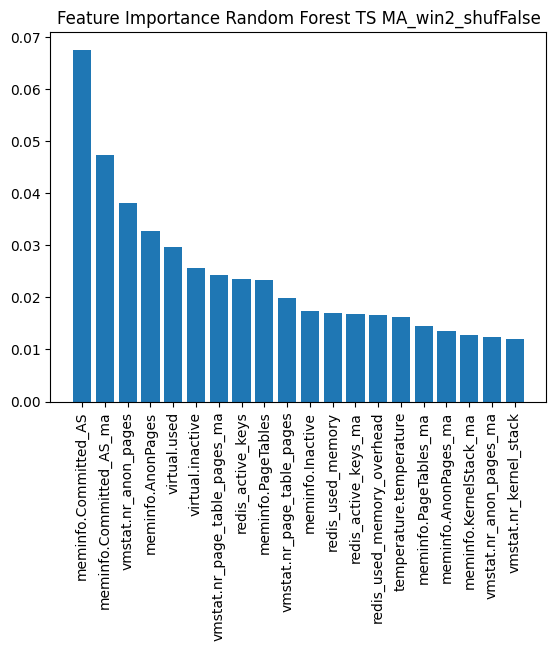

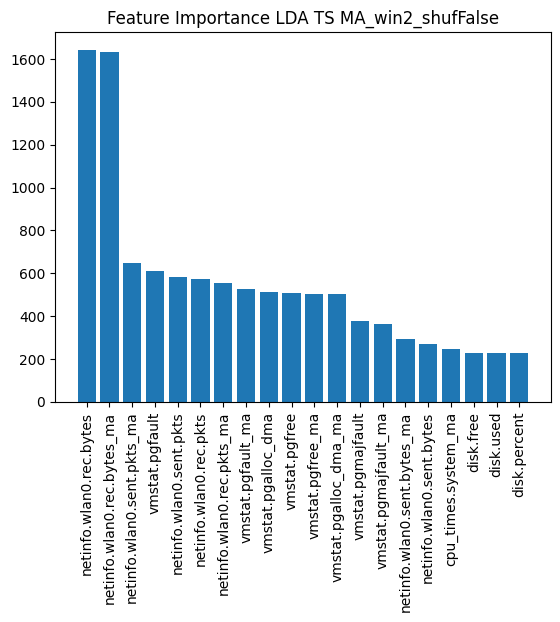

/var/folders/cs/nppv29k17nddrvw_mb475kjc0000gn/T/ipykernel_20145/3785871646.py:8: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  df[f'{x}_{i}'] =data[f'{x}']-data[f'{x}'].shift(i)
/var/folders/cs/nppv29k17nddrvw_mb475kjc0000gn/T/ipykernel_20145/2262210672.py:6: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  df[f'{x}_ma']=df[f'{x}'].rolling(window_length).mean()


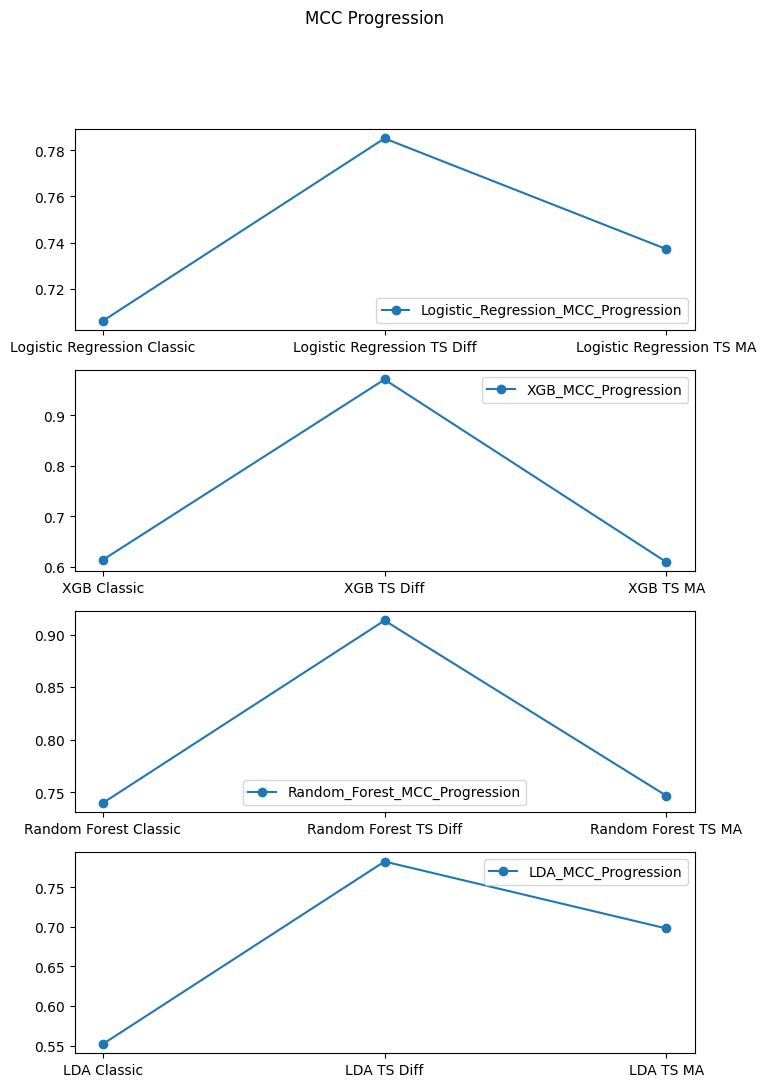

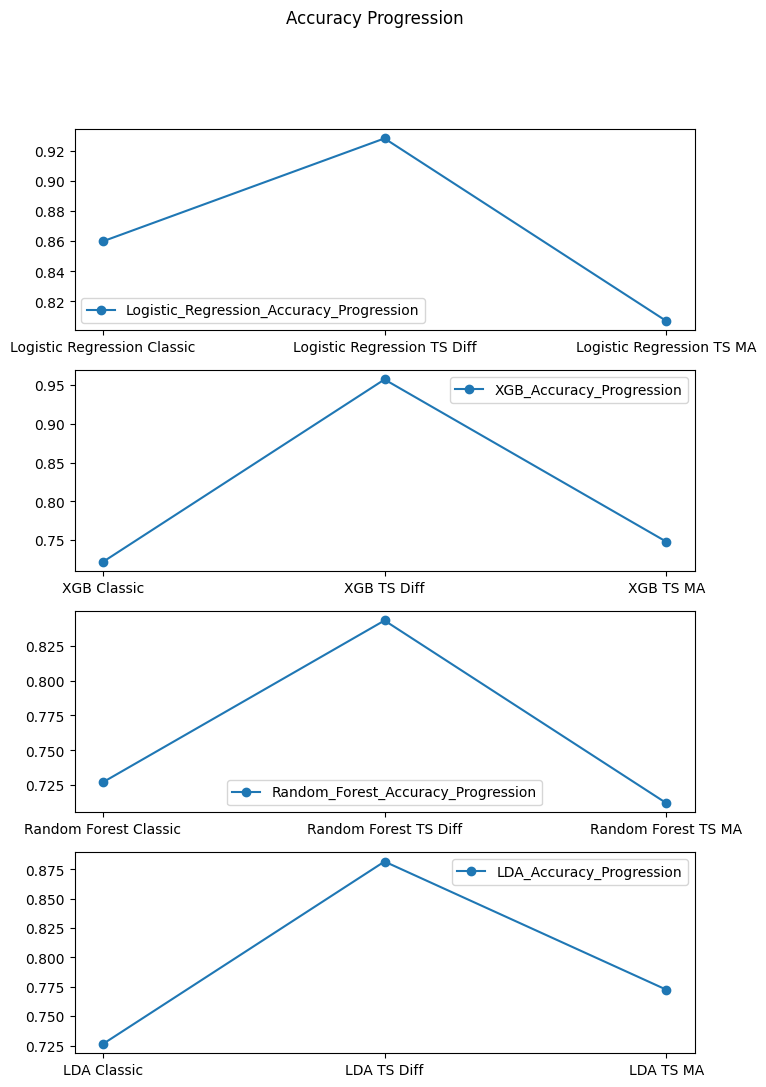

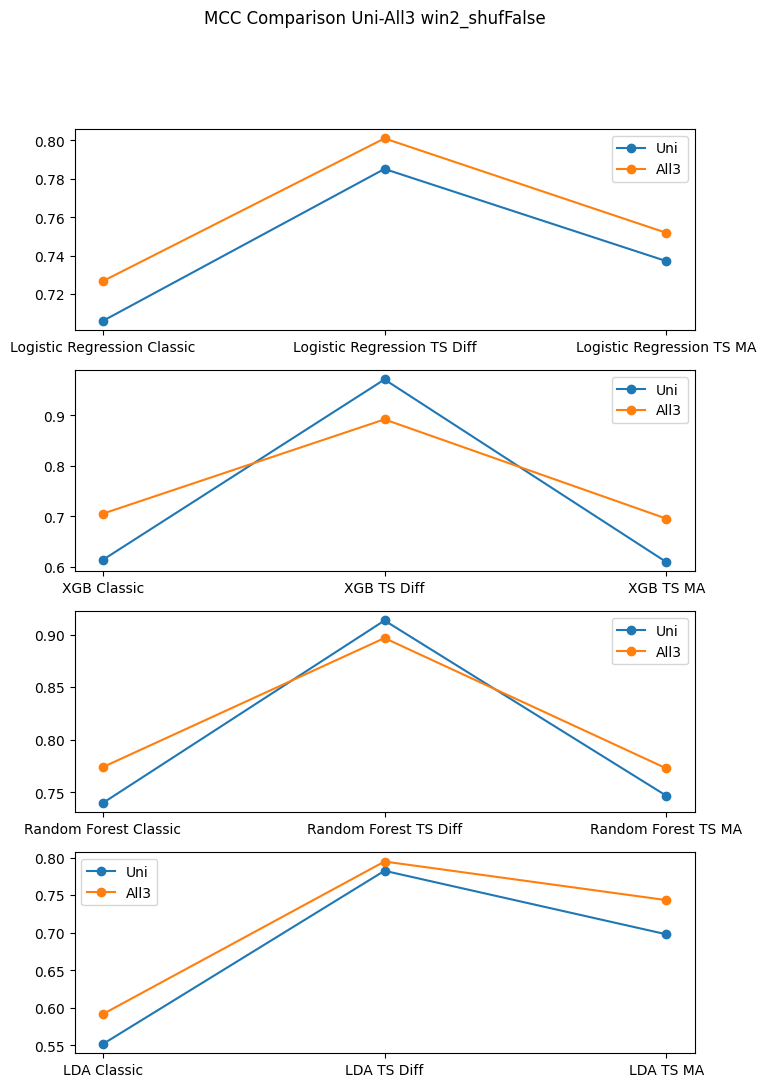

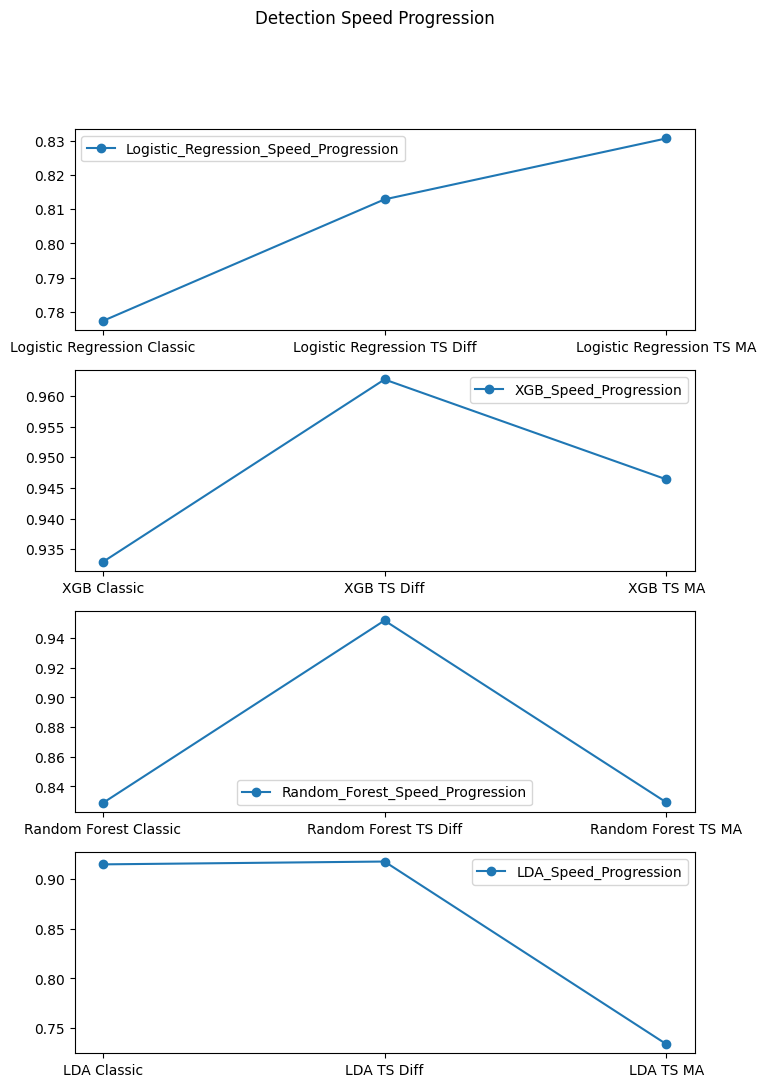

In [82]:
main_5()

In [158]:
def delete_unreliable_features_classic(columns_to_drop,model_name,csv_name):  
    X,y,df=preprocessing_base('preprocessed_arancino_datasets/unifi_filtered.csv')
    
    X=X.drop(columns=columns_to_drop)
    df=df.drop(columns=columns_to_drop)

    preprocessor=split_numerical_categorical_columns(X)
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, shuffle=False) 

    if(model_name=='XGB Classic'):
        model=my_XGB_pipeline(preprocessor,X_train,y_train)
    elif(model_name=='Logistic Regression Classic'):
        model=my_LogisticRegression_pipeline(preprocessor,X_train,y_train)
    elif(model_name=='Random Forest Classic'):
        model=my_RandomForest_pipeline(preprocessor,X_train,y_train)
    elif(model_name=='LDA Classic'):
        model=my_LDA_pipeline(preprocessor,X_train,y_train)

    MCC=(matthews_corrcoef(y_test, model.predict(X_test))+1)/2 # MCC scalato a [0,1]

    with open('mcc_csv/mcc_win5_shufFalse.csv', 'r') as csvfile:
        csvreader = csv.reader(csvfile)
        # Itera attraverso le righe del file
        for row in csvreader:
            if row[0]==model_name:
                value = row[1]

    with open(csv_name, 'a', newline='') as file:
            fieldnames = ['csv_note','MCC Without Unreliable Features','MCC With Unreliable Features']
            writer = csv.DictWriter(file, fieldnames=fieldnames)
            if is_csv_empty(csv_name):
                writer.writeheader()

            writer.writerow({'csv_note': model_name,'MCC Without Unreliable Features': MCC,'MCC With Unreliable Features': value})

    

In [159]:
#Delete XGB Unreliable Features
columns_to_drop=['net_io.bytes_sent','meminfo.Inactive','disk_io.read_bytes','cpu_times.iowait','vmstat.pgfree','temperature.temperature']
delete_unreliable_features_classic(columns_to_drop,'XGB Classic','mcc_without_unreliable_features.csv')

In [160]:
#Delete Logistic Regression Unreliable Features
columns_to_drop=['meminfo.MemFree','iostat.nice','disk_io.read_time','redis_used_cpu_sys','cpu_times.idle']
delete_unreliable_features_classic(columns_to_drop,'Logistic Regression Classic','mcc_without_unreliable_features.csv')

In [161]:
#Delete Random Forest Unreliable Features
columns_to_drop=['meminfo.MemAvailable','virtual.available','meminfo.Inactive','virtual.inactive']
delete_unreliable_features_classic(columns_to_drop,'Random Forest Classic','mcc_without_unreliable_features.csv')

In [162]:
#Delete LDA Unreliable Features
columns_to_drop=['cpu_times.idle','cpu_stats.ctx_switches','vmstat.pgreuse','cpu_times.nice','netinfo.lo.sent.pkts']
delete_unreliable_features_classic(columns_to_drop,'LDA Classic','mcc_without_unreliable_features.csv')